${\Huge \text{Comparison between variant annotation databases}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook is directly linked to [`doc/biblio/variant_annotation_databases.md`](https://github.com/PierreGuilmin/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md) which compares and describes different variant annotation databases. The aim of this notebook is to compare the annotations of some of the databases studied in the markdown with OncoKB annotations.

We will study different databases available online and compare them with OncoKB:
* [CanDL](https://github.com/PierreGuilmin/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#candl)
* [DoCM](https://github.com/PierreGuilmin/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#docm)
* [Precision Medicine Knowledgebase](https://github.com/PierreGuilmin/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#precision-medicine-knowledgebase) (couldn't finish)
* [CIViC](https://github.com/PierreGuilmin/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#civic)
* [Cancer Genome Interpreter](https://github.com/PierreGuilmin/impact-annotator/blob/master/doc/biblio/variant_annotation_databases.md#cancer-genome-interpreter)

This notebook is divided in 7 parts:

* **1. CanDL**
* **2. DoCM**
* **3. Precision Medicine Knowledgebase**
* **4. CIViC**
* **5. Cancer Genome Interpreter**
* **6. Study the IMPACT variants repartition accross the databases**
* **7. Study shared genes**

The process to study the database `another_database` will always be the same and each section (from 1 to 5)
will be divided in the following subsections:
1. Get the raw dataframe `another_database`
2. Create keys to join the dataframe `impact` and `another_database`. Two verifications to do:
    1. every key in `another_database` has unique values
    2. every key in `impact` has an analoguous key in `another_database`
3. Compare `another_database` annotations with OncoKB annotations

⚠️ The work presented here is "approximative" as we used a special tool to link our `impact` dataset with OncoKB (oncokb-annotator) while we're just trying here to link the other databases by hand, not always going into the most details to get every mutations.

***

In [1]:
source("../../utils/r/custom_tools.R")
setup_environment("../../utils/r")

In [2]:
# load dataset
impact <- read.table("../../data/processed/annotated_final_IMPACT_mutations_20181105.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE)

We will only work with the somatic mutations:

In [3]:
impact <- impact[impact$confidence_class %in% c("AUTO_OK", "MANUAL_OK"),] # keep only the somatic mutations

In [4]:
impact$is_in_oncokb <- "no"
impact$is_in_oncokb[impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic")] <- "yes"
get_table(impact$is_in_oncokb)

values,count,freq
no,140321,64.3%
yes,77852,35.7%
-- total --,218173,100%


# CanDL

## Get the raw data

Data downloaded from https://candl.osu.edu/download/full, 09/08/18 version.

In [5]:
candl <- read.table("../../data/other_databases/candl-results-20180809100701.csv",
                    sep = ",", stringsAsFactors = FALSE, header = TRUE)

In [6]:
print_size(candl)
length(unique(candl$Gene))
head(candl)

Size of candl: 1820 x 16

[1] 62

ID,Gene,Normal.AA,Peptide.Position,Mutation.AA,Chromosome,DNA.Position,Codon,Transcript,Gene.Strand,RNA.Position,Exon,Mutation.Codon,Cancer.Type,Level.of.Evidence,PMIDs
1,ABL1,T,212,R,9,133738234,ACG,uc004bzw.3,+,634,4,AGG,Chronic Myelocytic Leukemia,3,20519627
2,ABL1,T,212,R,9,133738235,ACG,uc004bzw.3,+,635,4,AGG,Chronic Myelocytic Leukemia,3,20519627
3,ABL1,T,212,R,9,133738236,ACG,uc004bzw.3,+,636,4,AGG,Chronic Myelocytic Leukemia,3,20519627
4,ABL1,G,250,E,9,133738348,GGG,uc004bzw.3,+,748,4,GAG,Chronic Myelocytic Leukemia,1,23190221
5,ABL1,G,250,E,9,133738349,GGG,uc004bzw.3,+,749,4,GAG,Chronic Myelocytic Leukemia,1,23190221
6,ABL1,G,250,E,9,133738350,GGG,uc004bzw.3,+,750,4,GAG,Chronic Myelocytic Leukemia,1,23190221


## Create keys to join the two dataframes and extract the features

We will join the databases using the following keys: 
* `Hugo_Symbol`.`HGVSp_Short` for `impact`
* `Gene`.p.`Normal.AA` `Peptide.Position` `Mutation.AA` for `candl`

In [7]:
impact$candl_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)
head(impact$candl_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7."         "FBXW7.p.G61*"

In [8]:
candl$join_key <- paste0(candl$Gene, '.p.', candl$Normal.AA, candl$Peptide.Position, candl$Mutation.AA)
head(candl$join_key)

[1] "ABL1.p.T212R" "ABL1.p.T212R" "ABL1.p.T212R" "ABL1.p.G250E" "ABL1.p.G250E"
[6] "ABL1.p.G250E"

**Verification 1** The `join_key` are not unique:

In [9]:
length(unique(candl$join_key))
nrow(candl)

[1] 345

[1] 1820

Looking closer at the data, every key is repeated a few times because every DNA 3-bp codon creating the protein change is in the database.

In [10]:
# make them unique
candl <- unique(candl[, c("Gene", "Normal.AA", "Peptide.Position", "Mutation.AA", "Chromosome", "join_key")])

length(unique(candl$join_key))
nrow(candl)

[1] 345

[1] 345

**Verification 2** not every impact `candl_key` has an analoguous `join_key` in `candl`.

In [11]:
impact$is_in_candl <- "no"
impact$is_in_candl[impact$candl_key %in% candl$join_key] <- "yes"

## Results

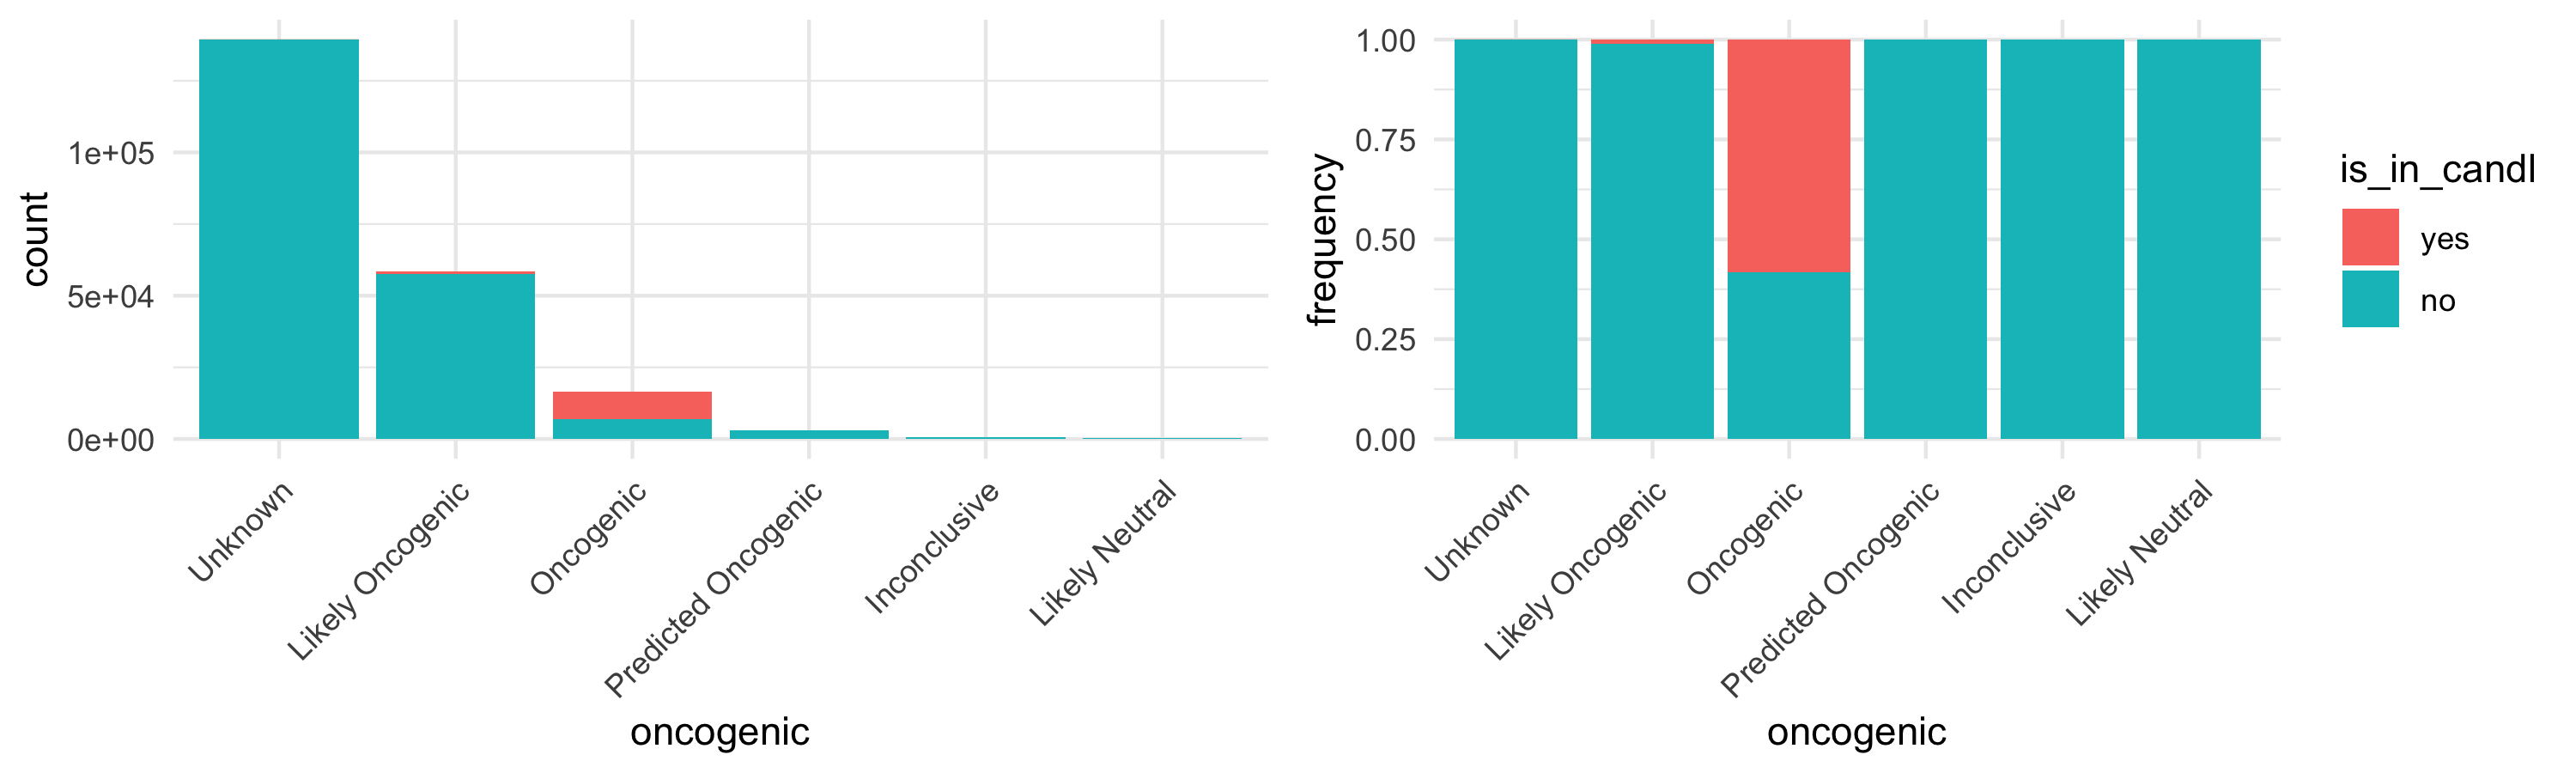

In [12]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_candl", 10, 3)

Putative drivers not found in OncoKB:

In [13]:
# number of rows
nrow(impact[impact$is_in_candl == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_candl == "yes" & impact$is_in_oncokb == "no"]))

[1] 74

[1] 15

# DoCM

## Get the raw data

Data downloaded from http://www.docm.info/api/v1/variants.tsv?versions=3.2, version 3.2 (13/08/17).

In [14]:
docm <- read.table("../../data/other_databases/DoCM_variants.tsv",
                   sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [15]:
print_size(docm)
length(unique(docm$gene))
head(docm)

Size of docm: 1364 x 12

[1] 132

hgvs,chromosome,start,stop,read,variant,reference_version,gene,mutation_type,amino_acid,diseases,pubmed_sources
ENST00000361445:c.7514G>C,1,11169361,11169361,C,G,GRCh37,MTOR,missense,p.R2505P,renal carcinoma,24631838
ENST00000361445:c.7500T>G,1,11169375,11169375,A,C,GRCh37,MTOR,missense,p.I2500M,"uterine corpus endometrial carcinoma,gastric adenocarcinoma,renal clear cell carcinoma,breast cancer",26619011
ENST00000361445:c.7498A>T,1,11169377,11169377,T,A,GRCh37,MTOR,missense,p.I2500F,"uterine corpus endometrial carcinoma,gastric adenocarcinoma,renal clear cell carcinoma,breast cancer",26619011
ENST00000361445:c.7255G>A,1,11174420,11174420,C,T,GRCh37,MTOR,missense,p.E2419K,urinary bladder urothelial carcinoma,24625776
ENST00000361445:c.6667C>A,1,11182179,11182179,G,T,GRCh37,MTOR,missense,p.Q2223K,renal carcinoma,24622468
ENST00000361445:c.6644C>A,1,11184573,11184573,G,T,GRCh37,MTOR,missense,p.S2215Y,"renal carcinoma,colorectal cancer,uterine corpus endometrial carcinoma,skin melanoma,cervix carcinoma,papillary renal cell carcinoma,renal clear cell carcinoma,glioblastoma multiforme","24631838,26619011"


In [16]:
interesting_columns <- c(
"hgvs",
"chromosome",
"start",
"stop",
"read",
"variant",
"reference_version",
"gene",
"mutation_type",
"amino_acid")

head(docm[, interesting_columns], 10)

hgvs,chromosome,start,stop,read,variant,reference_version,gene,mutation_type,amino_acid
ENST00000361445:c.7514G>C,1,11169361,11169361,C,G,GRCh37,MTOR,missense,p.R2505P
ENST00000361445:c.7500T>G,1,11169375,11169375,A,C,GRCh37,MTOR,missense,p.I2500M
ENST00000361445:c.7498A>T,1,11169377,11169377,T,A,GRCh37,MTOR,missense,p.I2500F
ENST00000361445:c.7255G>A,1,11174420,11174420,C,T,GRCh37,MTOR,missense,p.E2419K
ENST00000361445:c.6667C>A,1,11182179,11182179,G,T,GRCh37,MTOR,missense,p.Q2223K
ENST00000361445:c.6644C>A,1,11184573,11184573,G,T,GRCh37,MTOR,missense,p.S2215Y
ENST00000361445:c.6644C>T,1,11184573,11184573,G,A,GRCh37,MTOR,missense,p.S2215F
ENST00000361445:c.6643T>A,1,11184574,11184574,A,T,GRCh37,MTOR,missense,p.S2215T
ENST00000361445:c.6637C>T,1,11184580,11184580,G,A,GRCh37,MTOR,missense,p.P2213S
ENST00000361445:c.6324C>A,1,11187094,11187094,G,T,GRCh37,MTOR,missense,p.F2108L


## Create keys to join the two dataframes and extract the features

We will join the databases using the following keys: 
* `mut_key` for `impact`
* `chromosome`\_`start`\_`read`_`variant` for `docm`

In [17]:
docm$join_key <- paste(docm$chromosome, docm$start, docm$read, docm$variant, sep = "_")
head(docm$join_key)

[1] "1_11169361_C_G" "1_11169375_A_C" "1_11169377_T_A" "1_11174420_C_T"
[5] "1_11182179_G_T" "1_11184573_G_T"

**Verification 1** The `join_key` are not unique:

In [18]:
length(unique(docm$join_key))
nrow(docm)

[1] 1284

[1] 1364

In [19]:
# make them unique
docm <- unique(docm[, c("chromosome", "start", "stop", "read", "variant", "reference_version", "gene",
                        "mutation_type", "join_key")])

length(unique(docm$join_key))
nrow(docm)

[1] 1284

[1] 1284

**Verification 2** not every impact `mut_key` has an analoguous `join_key` in `docm`.

In [20]:
impact$is_in_docm <- "no"
impact$is_in_docm[impact$mut_key %in% docm$join_key] <- "yes"

## Results

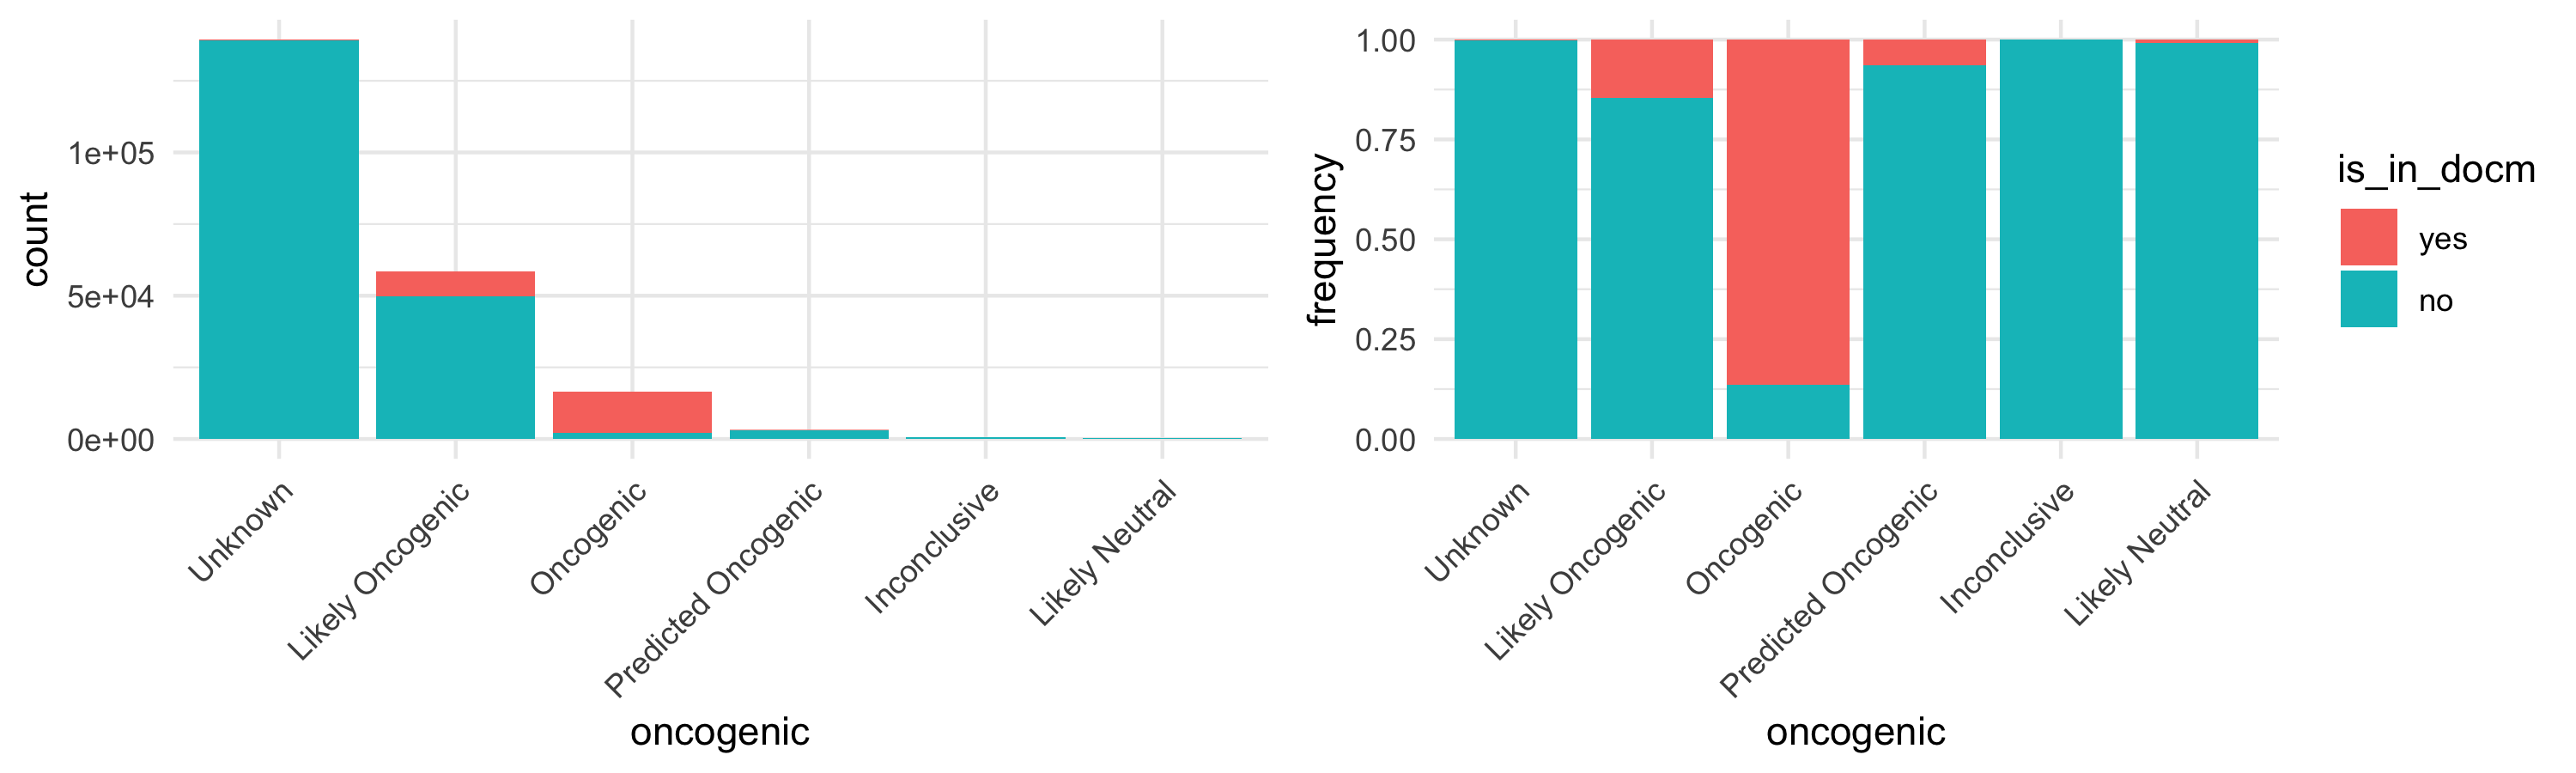

In [21]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_docm")

Putative drivers not found in OncoKB:

In [22]:
# number of rows
nrow(impact[impact$is_in_docm == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_docm == "yes" & impact$is_in_oncokb == "no"]))

[1] 208

[1] 43

# Precision Medicine Knowledgebase

## Get the raw data

Data downloaded from https://pmkb.weill.cornell.edu under "Welcome to Precision Medicine Knowledgebase", 02/08/18 version.

In [23]:
pmk <- readxl::read_excel("../../data/other_databases/PMK_IPM_Knowledgebase_Interpretations_Complete_20180807-1922.xlsx")

In [24]:
print_size(pmk)
length(unique(pmk$Gene))
colnames(pmk)

Size of pmk: 567 x 31

[1] 158

[1] "Gene"            "Tumor Type(s)"   "Tissue Type(s)"  "Variant(s)"     
 [5] "Tier"            "Interpretations" "Citations"       "X__1"           
 [9] "X__2"            "X__3"            "X__4"            "X__5"           
[13] "X__6"            "X__7"            "X__8"            "X__9"           
[17] "X__10"           "X__11"           "X__12"           "X__13"          
[21] "X__14"           "X__15"           "X__16"           "X__17"          
[25] "X__18"           "X__19"           "X__20"           "X__21"          
[29] "X__22"           "X__23"           "X__24"

In [25]:
interesting_columns <- c(
"Gene",
"Tumor Type(s)",
"Tissue Type(s)",
"Variant(s)",
"Tier")

head(pmk[, interesting_columns], 10)

Gene,Tumor Type(s),Tissue Type(s),Variant(s),Tier
CSF3R,"Atypical Chronic Myeloid Leukemia, Chronic Neutrophilic Leukemia, Myeloproliferative Neoplasm","Blood, Bone Marrow","CSF3R T618I, CSF3R any nonsense, CSF3R any frameshift",1
MPL,"Acute Myeloid Leukemia, Atypical Chronic Myeloid Leukemia, B Lymphoblastic Leukemia/Lymphoma, Chronic Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Chronic Neutrophilic Leukemia, Essential Thrombocythemia, Histiocytic and Dendritic Cell Neoplasms, Langerhans Cell Histiocytosis, Mast Cell Neoplasm, MDS with Ring Sideroblasts, Myelodysplastic Syndrome, Myeloproliferative Neoplasm, Polycythemia Vera, Primary Myelofibrosis, T Lymphoblastic Leukemia/Lymphoma, Leukocytosis, Thrombocytosis, Monocytosis, Cytopenia, Other Acute Leukemia, Acute Leukemia of Unspecified Cell Type, Anemia, Unspecified, Leukopenia, Thrombocytopenia, Unspecified, Eosinophilia, Myelodysplastic/Myeloproliferative Neoplasm, Myeloid Neoplasm, Polycythemia","Blood, Bone Marrow","MPL codon(s) 515 missense, MPL W515L, MPL W515K",1
JAK1,"Acute Myeloid Leukemia, Atypical Chronic Myeloid Leukemia, B Lymphoblastic Leukemia/Lymphoma, Chronic Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Chronic Neutrophilic Leukemia, Essential Thrombocythemia, Histiocytic and Dendritic Cell Neoplasms, Langerhans Cell Histiocytosis, Mast Cell Neoplasm, MDS with Ring Sideroblasts, Myelodysplastic Syndrome, Myeloproliferative Neoplasm, Polycythemia Vera, Primary Myelofibrosis, T Lymphoblastic Leukemia/Lymphoma, Leukocytosis, Thrombocytosis, Monocytosis, Cytopenia, Other Acute Leukemia, Acute Leukemia of Unspecified Cell Type, Anemia, Unspecified, Leukopenia, Thrombocytopenia, Unspecified, Eosinophilia, Myelodysplastic/Myeloproliferative Neoplasm, Myeloid Neoplasm, Polycythemia","Blood, Bone Marrow",JAK1 any mutation,2
NRAS,"Acute Myeloid Leukemia, Atypical Chronic Myeloid Leukemia, B Lymphoblastic Leukemia/Lymphoma, Chronic Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Chronic Neutrophilic Leukemia, Essential Thrombocythemia, Histiocytic and Dendritic Cell Neoplasms, Langerhans Cell Histiocytosis, Mast Cell Neoplasm, MDS with Ring Sideroblasts, Myelodysplastic Syndrome, Myeloproliferative Neoplasm, Polycythemia Vera, Primary Myelofibrosis, T Lymphoblastic Leukemia/Lymphoma, Leukocytosis, Thrombocytosis, Monocytosis, Cytopenia, Other Acute Leukemia, Acute Leukemia of Unspecified Cell Type, Anemia, Unspecified, Leukopenia, Thrombocytopenia, Unspecified, Eosinophilia, Myelodysplastic/Myeloproliferative Neoplasm, Myeloid Neoplasm, Polycythemia","Blood, Bone Marrow",NRAS any mutation,1
NOTCH2,"Diffuse Large B Cell Lymphoma, Marginal Zone B Cell Lymphoma","Blood, Bone Marrow","NOTCH2 I2304fs, NOTCH2 exon(s) 34 frameshift",1
RIT1,"Acute Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Myelodysplastic Syndrome","Blood, Bone Marrow",RIT1 M90I,1
DNMT3A,"Acute Myeloid Leukemia, Atypical Chronic Myeloid Leukemia, B Lymphoblastic Leukemia/Lymphoma, Chronic Myeloid Leukemia, Chronic Myelomonocytic Leukemia, Chronic Neutrophilic Leukemia, Essential Thrombocythemia, Histiocytic and Dendritic Cell Neoplasms, Langerhans Cell Histiocytosis, Mast Cell Neoplasm, MDS with Ring Sideroblasts, Myelodysplastic Syndrome, Myeloproliferative Neoplasm, Polycythemia Vera, Primary Myelofibrosis, T Lymphoblastic Leukemia/Lymphoma, Leukocytosis, Thrombocytosis, Monocytosis, Cytopenia, Other Acute Leukemia, Acute Leukemia of Unspecified Cell Type, Anemia, Unspecified, Leukopenia, Thrombocytopenia, Unspecified, Eosinophilia, Myelodysplastic/Myeloproliferative Neoplasm, Myeloid Neoplasm, Polycythemia","Blood, Bone Marrow","DNMT3A codon(s) 882 missense, DNMT3A any mutation",2
FANCL,Myelodysplastic Syndrome,"Blood, Bone Marrow",NA,1
XPO1,Chronic Lymphocytic Leukemia,"Blood, Bone Marrow",NA,1
CXCR4,Lymphoplasmacytic Lymphoma,"Blood, Bone Marrow",NA,1


We stopped here as there is no easy way to link this database with `impact`.

# CIViC

Data downloaded from https://civicdb.org/releases under "Variant Summaries", 01/07/18 version.

In [26]:
civic <- read.table("../../data/other_databases/CIViC_01-Jul-2018-VariantSummaries.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [27]:
print_size(civic)
length(unique(civic$gene))
colnames(civic)

Size of civic: 1885 x 23

[1] 353

[1] "variant_id"                 "variant_civic_url"         
 [3] "gene"                       "entrez_id"                 
 [5] "variant"                    "summary"                   
 [7] "variant_groups"             "chromosome"                
 [9] "start"                      "stop"                      
[11] "reference_bases"            "variant_bases"             
[13] "representative_transcript"  "ensembl_version"           
[15] "reference_build"            "chromosome2"               
[17] "start2"                     "stop2"                     
[19] "representative_transcript2" "variant_types"             
[21] "hgvs_expressions"           "last_review_date"          
[23] "civic_actionability_score"

In [28]:
interesting_columns <- c(
"gene",
"variant",
"chromosome",
"start",
"stop",
"reference_bases",
"variant_bases",
"representative_transcript",
"ensembl_version",
"reference_build",
"variant_types",
"hgvs_expressions",
"civic_actionability_score")

head(civic[, interesting_columns], 10)

gene,variant,chromosome,start,stop,reference_bases,variant_bases,representative_transcript,ensembl_version,reference_build,variant_types,hgvs_expressions,civic_actionability_score
ABL1,BCR-ABL,22,23522397,23632600,,,ENST00000305877.8,75,GRCh37,transcript_fusion,,238.0
ABL1,BCR-ABL T334I,9,133748283,133748283,C,T,ENST00000372348.2,75,GRCh37,"transcript_fusion,missense_variant","NM_007313.2:c.1001C>T,NP_005148.2:p.Thr315Ile,ENST00000372348.2:c.1001C>T,NC_000009.11:g.133748283C>T",54.0
ABL1,BCR-ABL E255K,9,133738363,133738363,G,A,ENST00000318560.5,75,GRCh37,"transcript_fusion,missense_variant","NC_000009.11:g.133738363G>A,NM_005157.5:c.763G>A,NP_005148.2:p.Glu255Lys,ENST00000318560.5:c.763G>A",17.0
AKT1,E17K,14,105246551,105246551,C,T,ENST00000407796.2,75,GRCh37,missense_variant,"NC_000014.8:g.105246551C>T,NM_001014432.1:c.49G>A,NP_001014432.1:p.Glu17Lys,ENST00000407796.2:c.49G>A",32.5
ALK,EML4-ALK,2,42396490,42522656,,,ENST00000318522.5,75,GRCh37,transcript_fusion,,48.0
ALK,EML4-ALK C1156Y,2,29445258,29445258,C,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3467G>A,NC_000002.11:g.29445258C>T,NM_004304.4:c.3467G>A,NP_004295.2:p.Cys1156Tyr",19.0
ALK,EML4-ALK L1196M,2,29443631,29443631,G,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3586C>A,NC_000002.11:g.29443631G>T,NM_004304.4:c.3586C>A,NP_004295.2:p.Leu1196Met",31.0
ALK,F1174L,2,29443695,29443695,G,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3522C>A,NP_004295.2:p.Phe1174Leu,NC_000002.11:g.29443695G>T,ENST00000389048.3:c.3522C>A",33.5
ALK,R1275Q,2,29432664,29432664,C,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3824G>A,NP_004295.2:p.Arg1275Gln,NC_000002.11:g.29432664C>T,ENST00000389048.3:c.3824G>A",23.0
ARAF,S214C,X,47426121,47426121,C,G,ENST00000377045.4,75,GRCh37,missense_variant,"NC_000023.10:g.47426121C>G,NM_001654.4:c.641C>G,NP_001645.1:p.Ser214Cys,ENST00000377045.4:c.641C>G",11.0


## Create keys to join the two dataframes and extract the features

We will join the databases using the following keys: 
* `mut_key` for `impact`
* `chromosome`\_`start`_`reference_bases`_`variant_bases` for `civic`

In [29]:
civic$join_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep = "_")

# sometimes we can't find a key
civic$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

head(civic$join_key)

[1] "no_key"           "9_133748283_C_T"  "9_133738363_G_A"  "14_105246551_C_T"
[5] "no_key"           "2_29445258_C_T"

A lot of variant are `EXON 21 DELETION`, `DELETION`, `AMPLIFICATION` instead of a precise mutation, that's why we can't compute a key for these variants, we won't work with them and thus a lot of mutations are not considered in the study that follows.

In [30]:
print_count_and_proportion(nrow(civic[civic$join_key == "no_key",]), nrow(civic))

# delete the rows where we couldn't find a key
civic <- civic[civic$join_key != "no_key",]

[1] "1082 over 1885 (57.40%)"

**Verification 1** The `join_key` are not unique:

In [31]:
length(unique(civic$join_key))
nrow(civic)

[1] 797

[1] 803

In [32]:
# make them unique
civic <- unique(civic[, c("gene", "chromosome", "start", "stop", "reference_bases", "variant_bases", "join_key")])

length(unique(civic$join_key))
nrow(civic)

[1] 797

[1] 797

**Verification 2** not every impact `mut_key` has an analoguous `join_key` in `civic`.

In [33]:
impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$join_key] <- "yes"

## Results

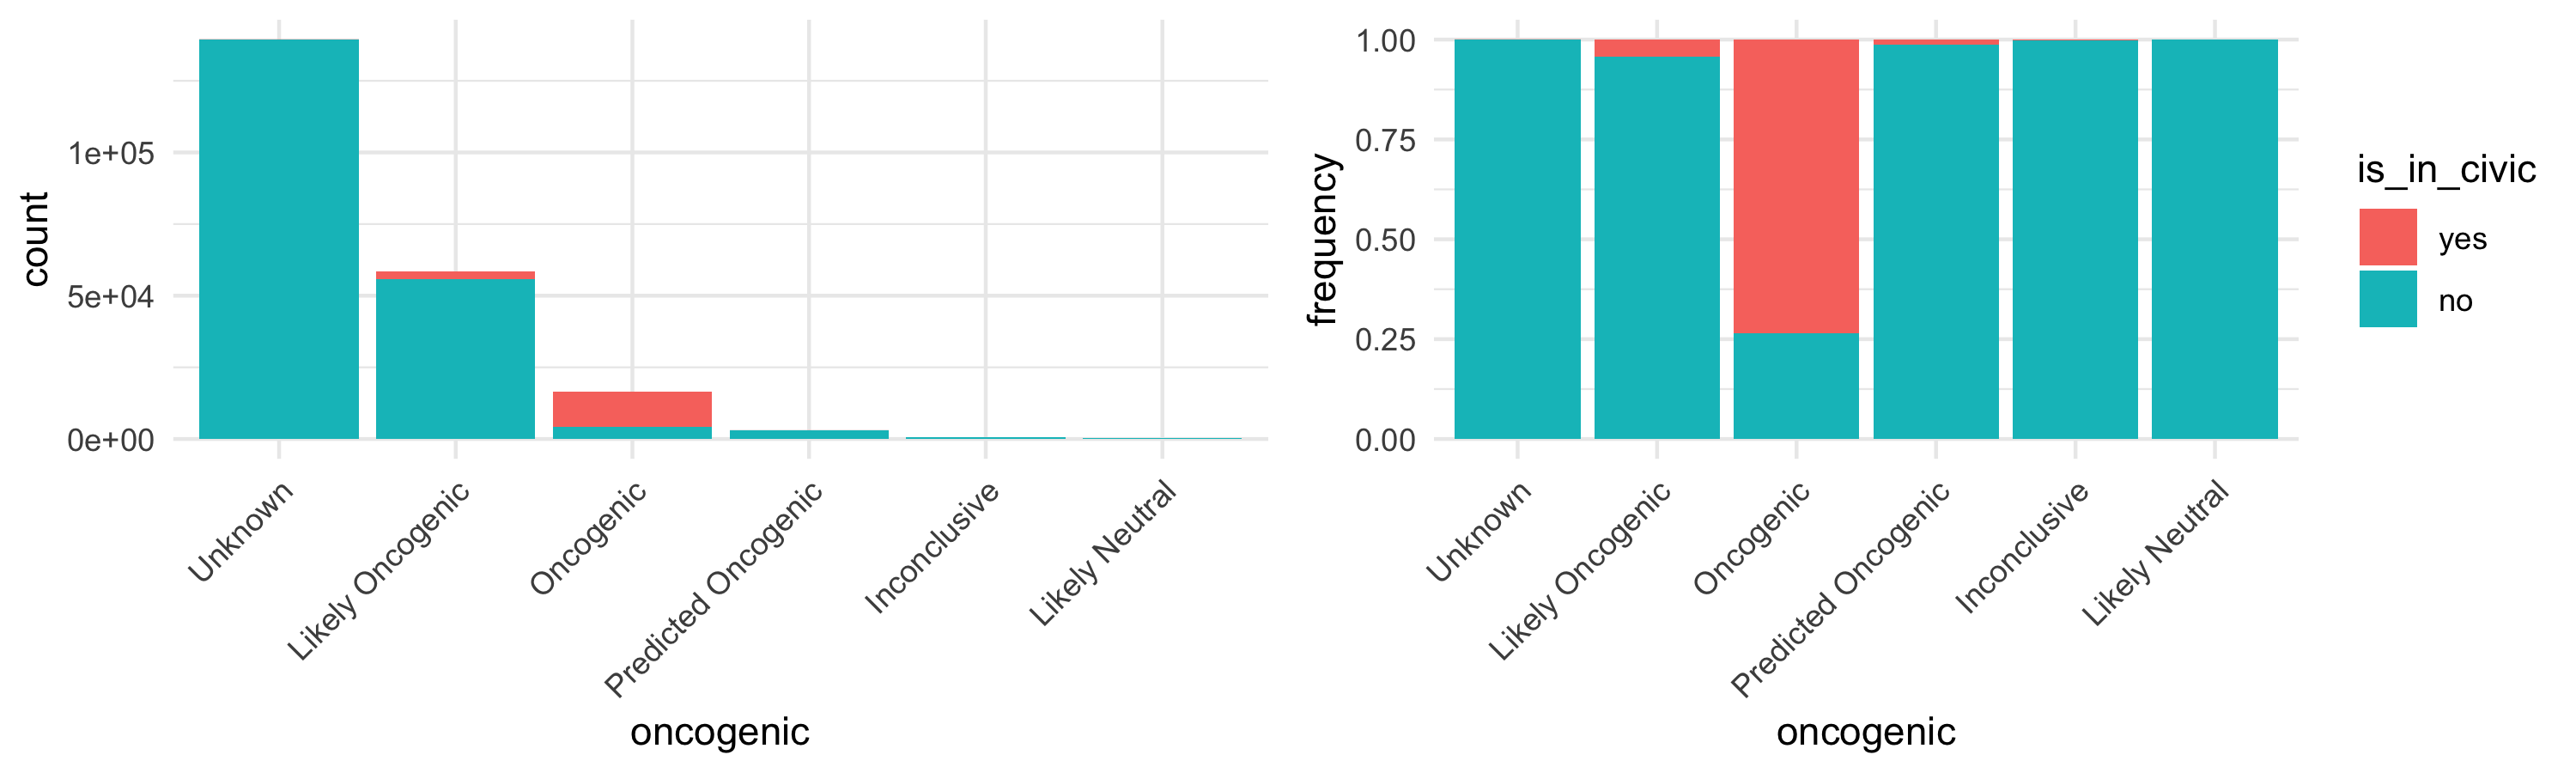

In [34]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_civic")

Putative drivers not found in OncoKB:

In [35]:
# number of rows
nrow(impact[impact$is_in_civic == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_civic == "yes" & impact$is_in_oncokb == "no"]))

[1] 90

[1] 30

# Cancer Genome Interpreter

## Get the raw data

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [36]:
cgi <- read.table("../../data/other_databases/CGI_catalog_of_validated_oncogenic_mutations.tsv",
                  sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [37]:
print_size(cgi)
length(unique(cgi$gene))
head(cgi)

Size of cgi: 5601 x 9

[1] 247

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040


## Create keys to join the two dataframes and extract the features

We will join the databases using the following keys: 
* `Hugo_Symbol`.`HGVSp_Short` for `impact`
* `gene`.`protein` for `cgi`

In [38]:
impact$cgi_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)
head(impact$cgi_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7."         "FBXW7.p.G61*"

In [39]:
cgi$join_key <- paste0(cgi$gene, '.', cgi$protein)
head(cgi$join_key)

[1] "ABCB4.."      "ABL1.p.E236K" "ABL1.p.M237V" "ABL1.p.I242T" "ABL1.p.M244V"
[6] "ABL1.p.K247R"

We are going to link the databases on the exact `join_key`, and we will lost some mutations, for example `FBXW7.p.G61*` and `FBXW7.p.E62*` are likely to have the same effect but maybe only the first one is in cgi. The study that follows is thus not complete.

**Verification 1** The `join_key` are not unique:

In [40]:
length(unique(cgi$join_key))
nrow(cgi)

[1] 5232

[1] 5601

In [41]:
# make them unique
cgi <- unique(cgi[, c("gene", "protein", "join_key")])

length(unique(cgi$join_key))
nrow(cgi)

[1] 5232

[1] 5232

**Verification 2** not every impact `cgi_key` has an analoguous `join_key` in `cgi`.

In [42]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$cgi_key %in% cgi$join_key] <- "yes"

## Results

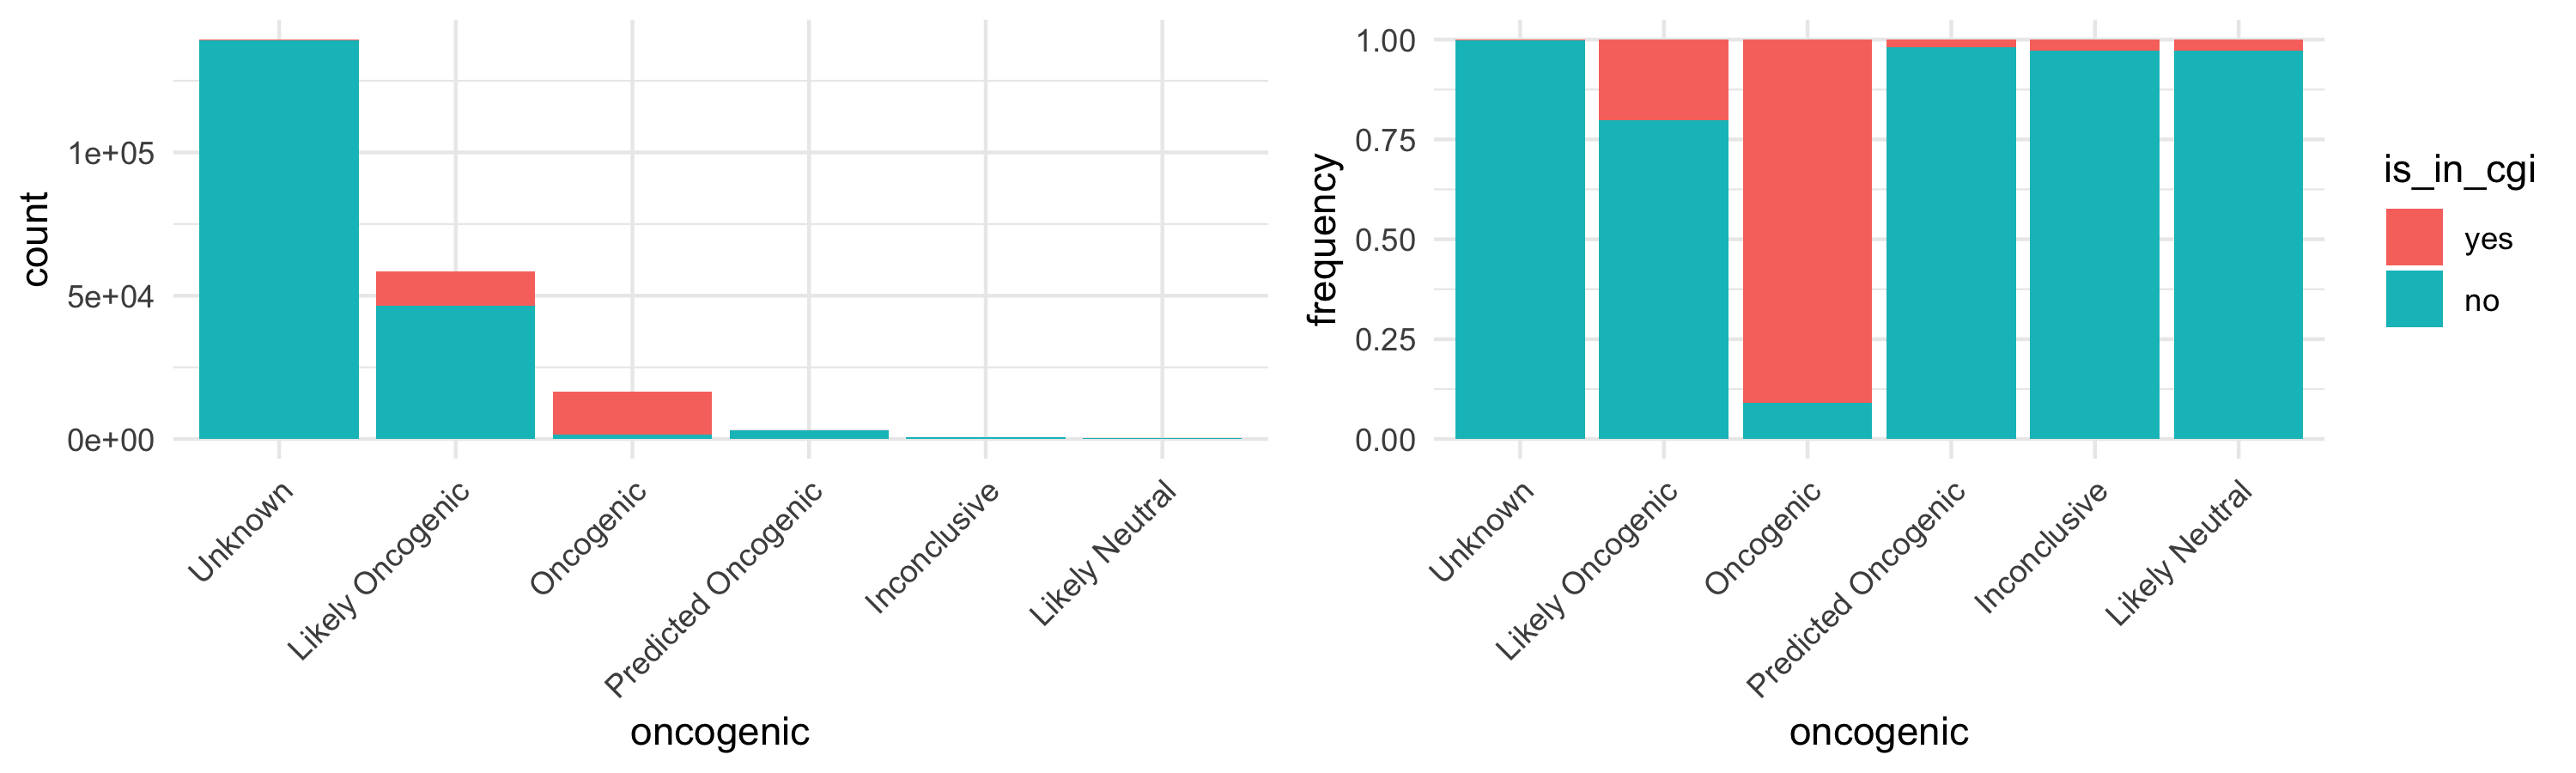

In [43]:
plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_cgi")

Putative drivers not found in OncoKB:

In [44]:
# number of rows
nrow(impact[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no"]))

[1] 189

[1] 78

## Other linking method

Let's try to link the other databases by being less specific on the `join_key`:
* `Hugo_Symbol`.`HGVSp_Short` for `impact` and `Hugo_Symbol`.`trunc` when the mutation is truncating
* `gene`.`protein` for `cgi` and `gene`.`trunc` when the mutation is truncating

In [45]:
cgi <- read.table("../../data/other_databases/CGI_catalog_of_validated_oncogenic_mutations.tsv",
                  sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [46]:
impact$cgi_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)

is_trunc <- which(impact$Consequence %in% c("splicing", "stopgain_SNV", "frameshift_insertion"))
impact$cgi_key[is_trunc] <- paste0(impact$Hugo_Symbol[is_trunc], ".trunc")
head(impact$cgi_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7.trunc"    "FBXW7.trunc"

In [47]:
get_cgi_consequence <- function(info_string) {
    info_string <- strsplit(info_string, ";")[[1]][1]
    info_string <- strsplit(info_string, '=')[[1]][2]
    
    return (info_string)
}

get_cgi_consequence("CSQN=Missense;reference_codon=GGG;candidate_codons=GAG,GAA;candidate_mnv_variants=chr9:g.133738349_133738350delGGinsAA;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;codon_pos=133738348-133738349-133738350;ref_codon_seq=GGG;aliases=ENSP00000323315;source=Ensembl")

[1] "Missense"

In [48]:
cgi$Consequence <- sapply(cgi$info, get_cgi_consequence)
get_table(cgi$Consequence)

values,count,freq
Missense,2905,51.9%
Frameshift,1464,26.1%
Nonsense,905,16.2%
SpliceDonorSNV,100,1.8%
SpliceAcceptorSNV,100,1.8%
InFrameDeletion,29,0.5%
SpliceAcceptorDeletion,16,0.3%
Synonymous,13,0.2%
CdsStartSNV,13,0.2%
MultiAAMissense,12,0.2%


In [49]:
truncating_mutations <- c("Frameshift", "Nonsense", "SpliceDonorSNV", "SpliceAcceptorSNV", "SpliceAcceptorDeletion")

In [50]:
cgi$protein[cgi$Consequence %in% c("Frameshift", "Nonsense", "SpliceDonorSNV", "SpliceAcceptorSNV", "SpliceAcceptorDeletion")] <- "trunc"

In [51]:
cgi$join_key <- paste0(cgi$gene, '.', cgi$protein)

is_trunc <- which(cgi$Consequence %in% c("Frameshift", "Nonsense", "SpliceDonorSNV", "SpliceAcceptorSNV", "SpliceAcceptorDeletion"))
cgi$join_key[is_trunc] <- paste0(cgi$gene[is_trunc], ".trunc")
head(impact$cgi_key)

[1] "TP53.p.T256P"   "PIK3R3.p.I298M" "ATR.p.R2431M"   "PDGFRA.p.L465M"
[5] "FBXW7.trunc"    "FBXW7.trunc"

Make the `join_key` unique:

In [52]:
cgi <- unique(cgi[, c("gene", "join_key")])

length(unique(cgi$join_key))
nrow(cgi)

[1] 2948

[1] 2948

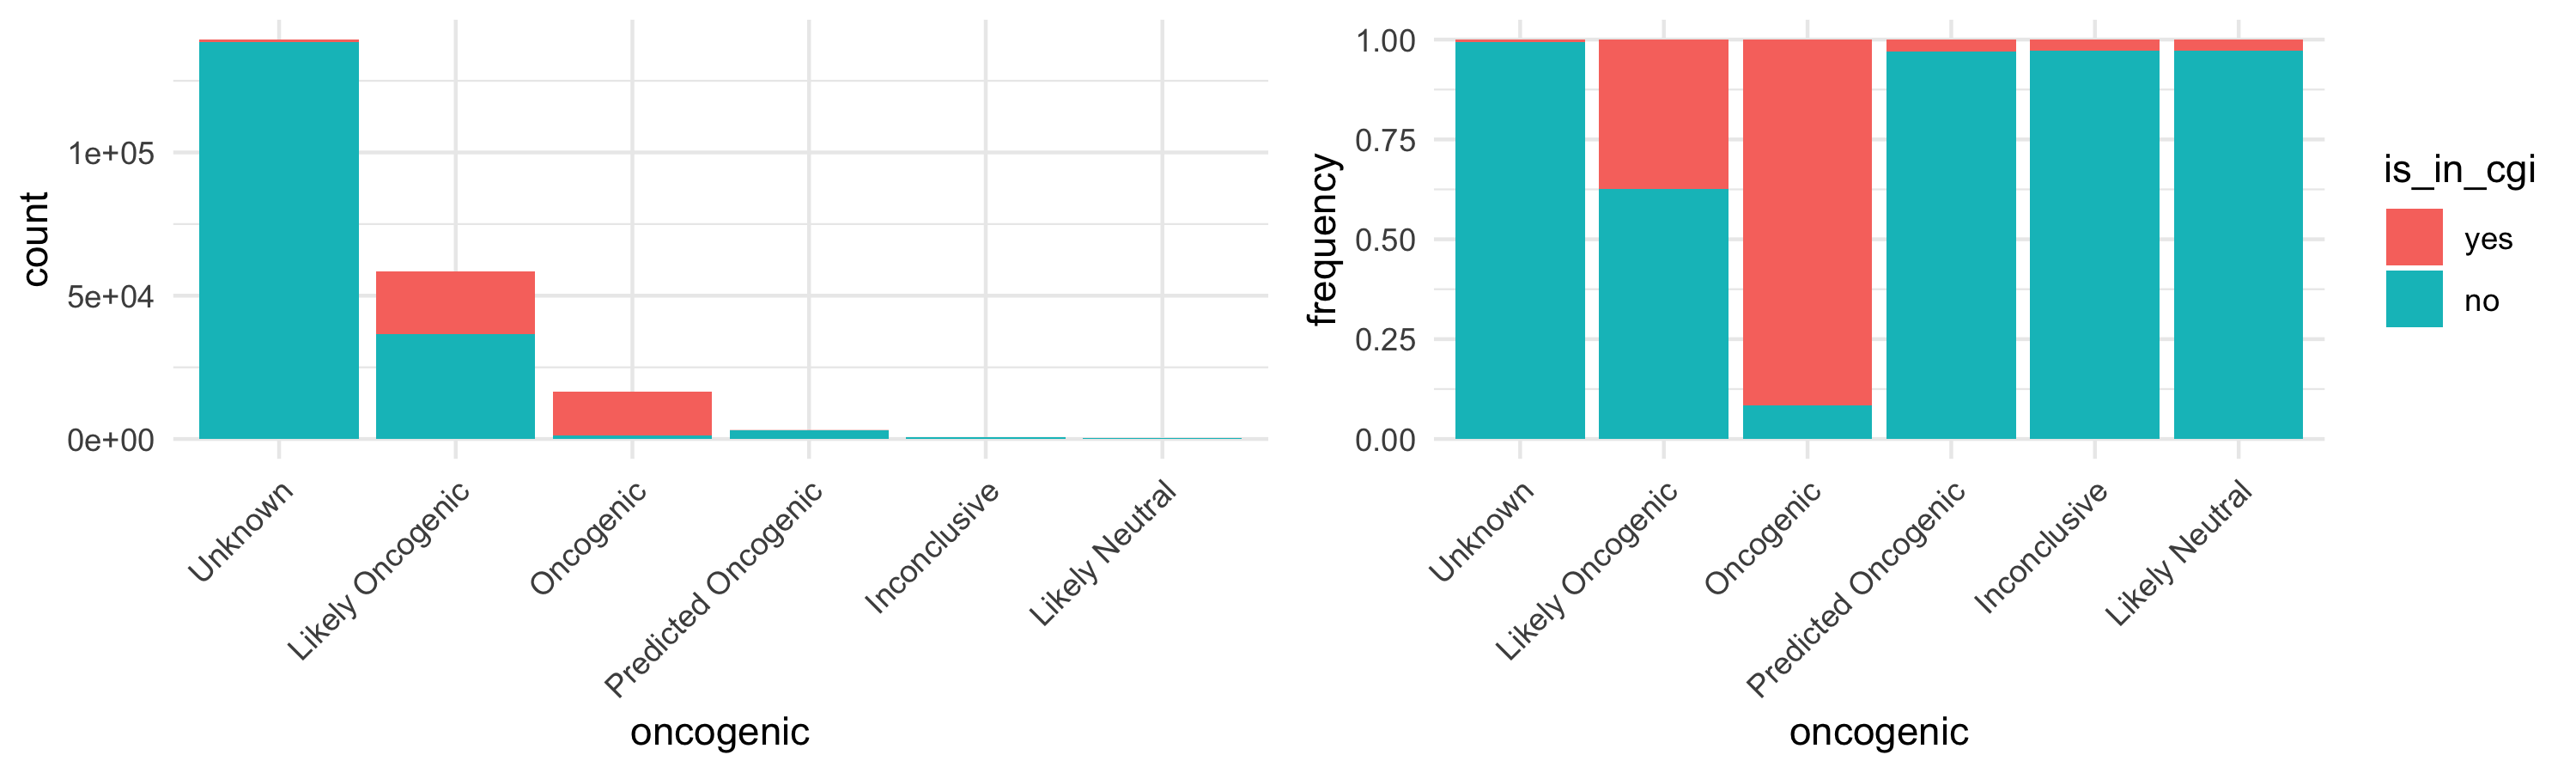

In [53]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$cgi_key %in% cgi$join_key] <- "yes"

plot_contingency_table_as_histograms(impact, "oncogenic"  , "is_in_cgi")

In [54]:
# number of rows
nrow(impact[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(impact$mut_key[impact$is_in_cgi == "yes" & impact$is_in_oncokb == "no"]))

[1] 844

[1] 557

# Study the IMPACT variants repartition accross the databases

In [55]:
oncokb_mutations <- impact[impact$is_in_oncokb == "yes",]
candl_mutations  <- impact[impact$is_in_candl  == "yes",]
docm_mutations   <- impact[impact$is_in_docm   == "yes",]
civic_mutations  <- impact[impact$is_in_civic  == "yes",]
cgi_mutations    <- impact[impact$is_in_cgi    == "yes",]

oncokb_mutations$database <- "oncokb"
candl_mutations$database  <- "candl"
docm_mutations$database   <- "docm"
civic_mutations$database  <- "civic"
cgi_mutations$database    <- "cgi"

annotated_mutations <- rbind(oncokb_mutations, candl_mutations, docm_mutations, civic_mutations, cgi_mutations)

In [56]:
impact$category <- "not found"
impact$category[impact$is_in_oncokb == "yes"] <- "oncokb"
impact$category[impact$is_in_oncokb == "no" &
                (impact$is_in_candl  == "yes" |
                 impact$is_in_docm   == "yes" |
                 impact$is_in_civic  == "yes" |
                 impact$is_in_cgi    == "yes")] <- "candl, docm, civic or cgi"
get_table(impact$category)

values,count,freq
not found,139279,63.8%
oncokb,77852,35.7%
"candl, docm, civic or cgi",1042,0.5%
-- total --,218173,100%


## At the row level

In [57]:
annotated_mutations <- as.data.frame(annotated_mutations %>% group_by(mut_key) %>%
                                                             mutate(count = length(unique(database)),
                                                                    repartition = toString(unique(database))))

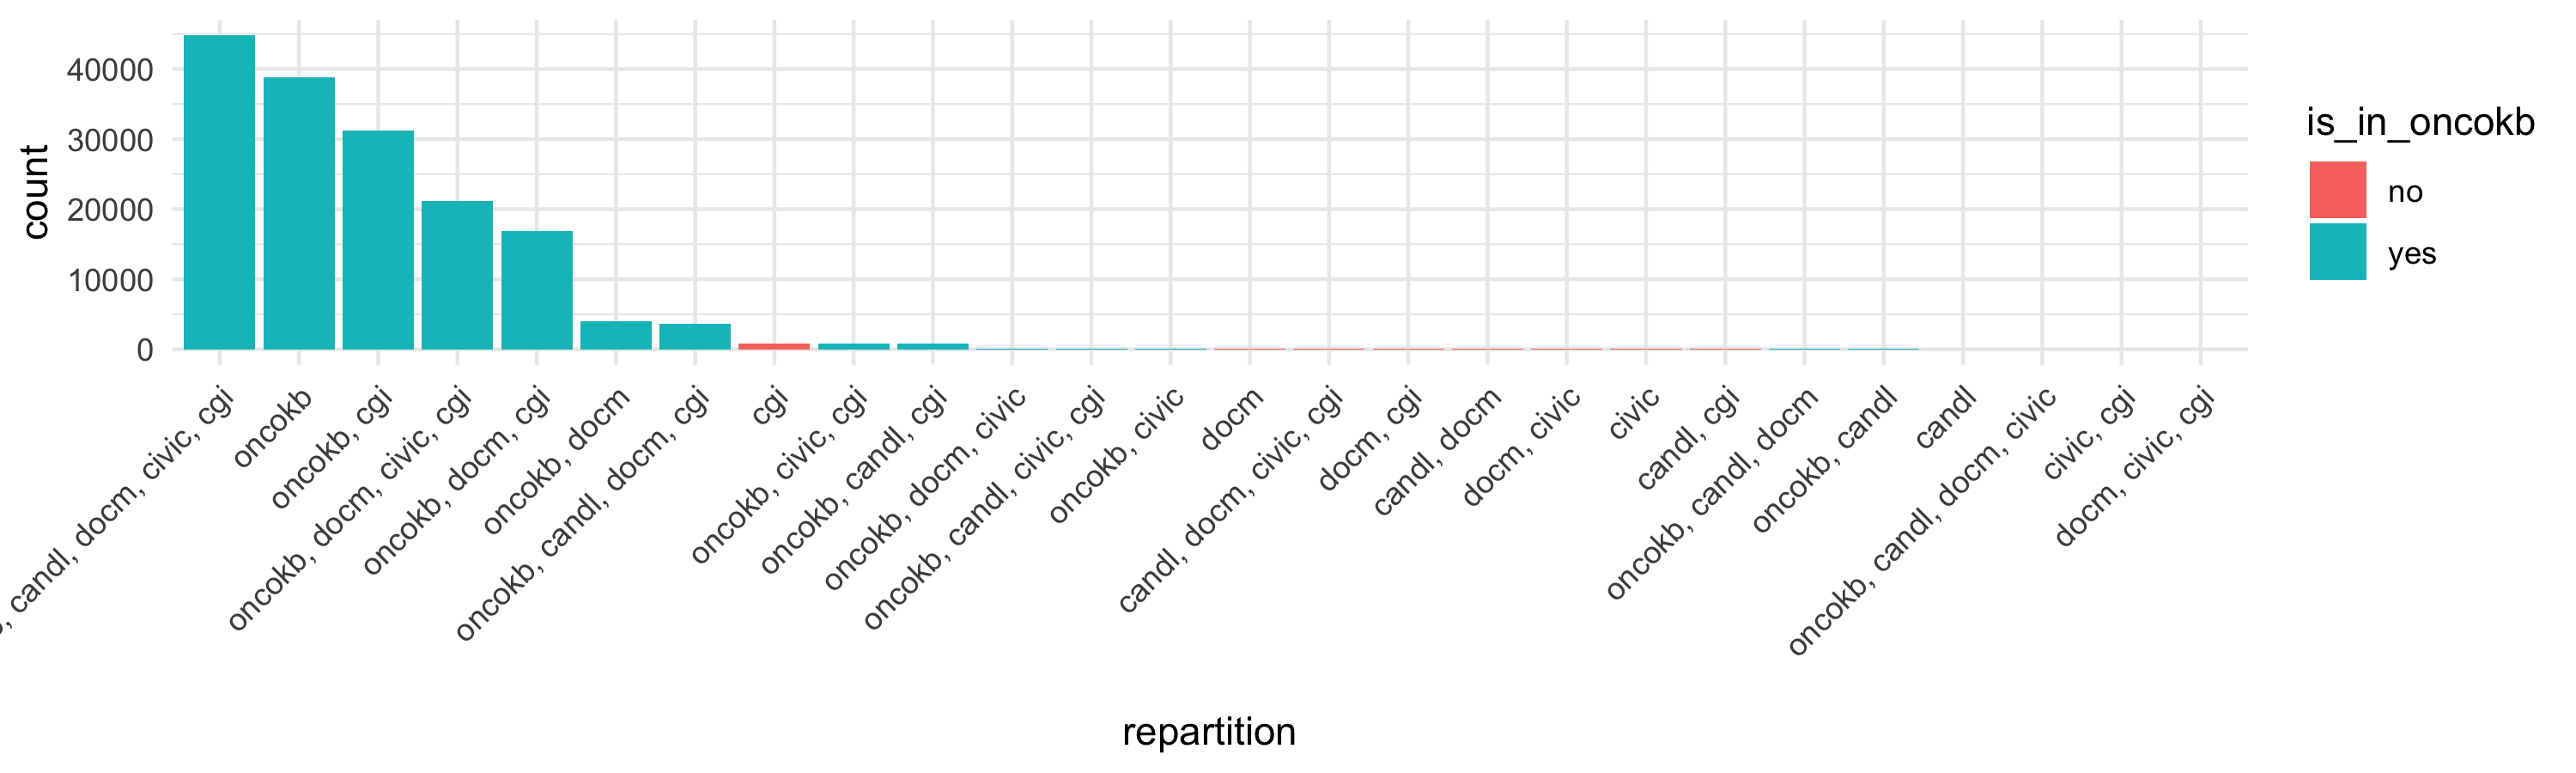

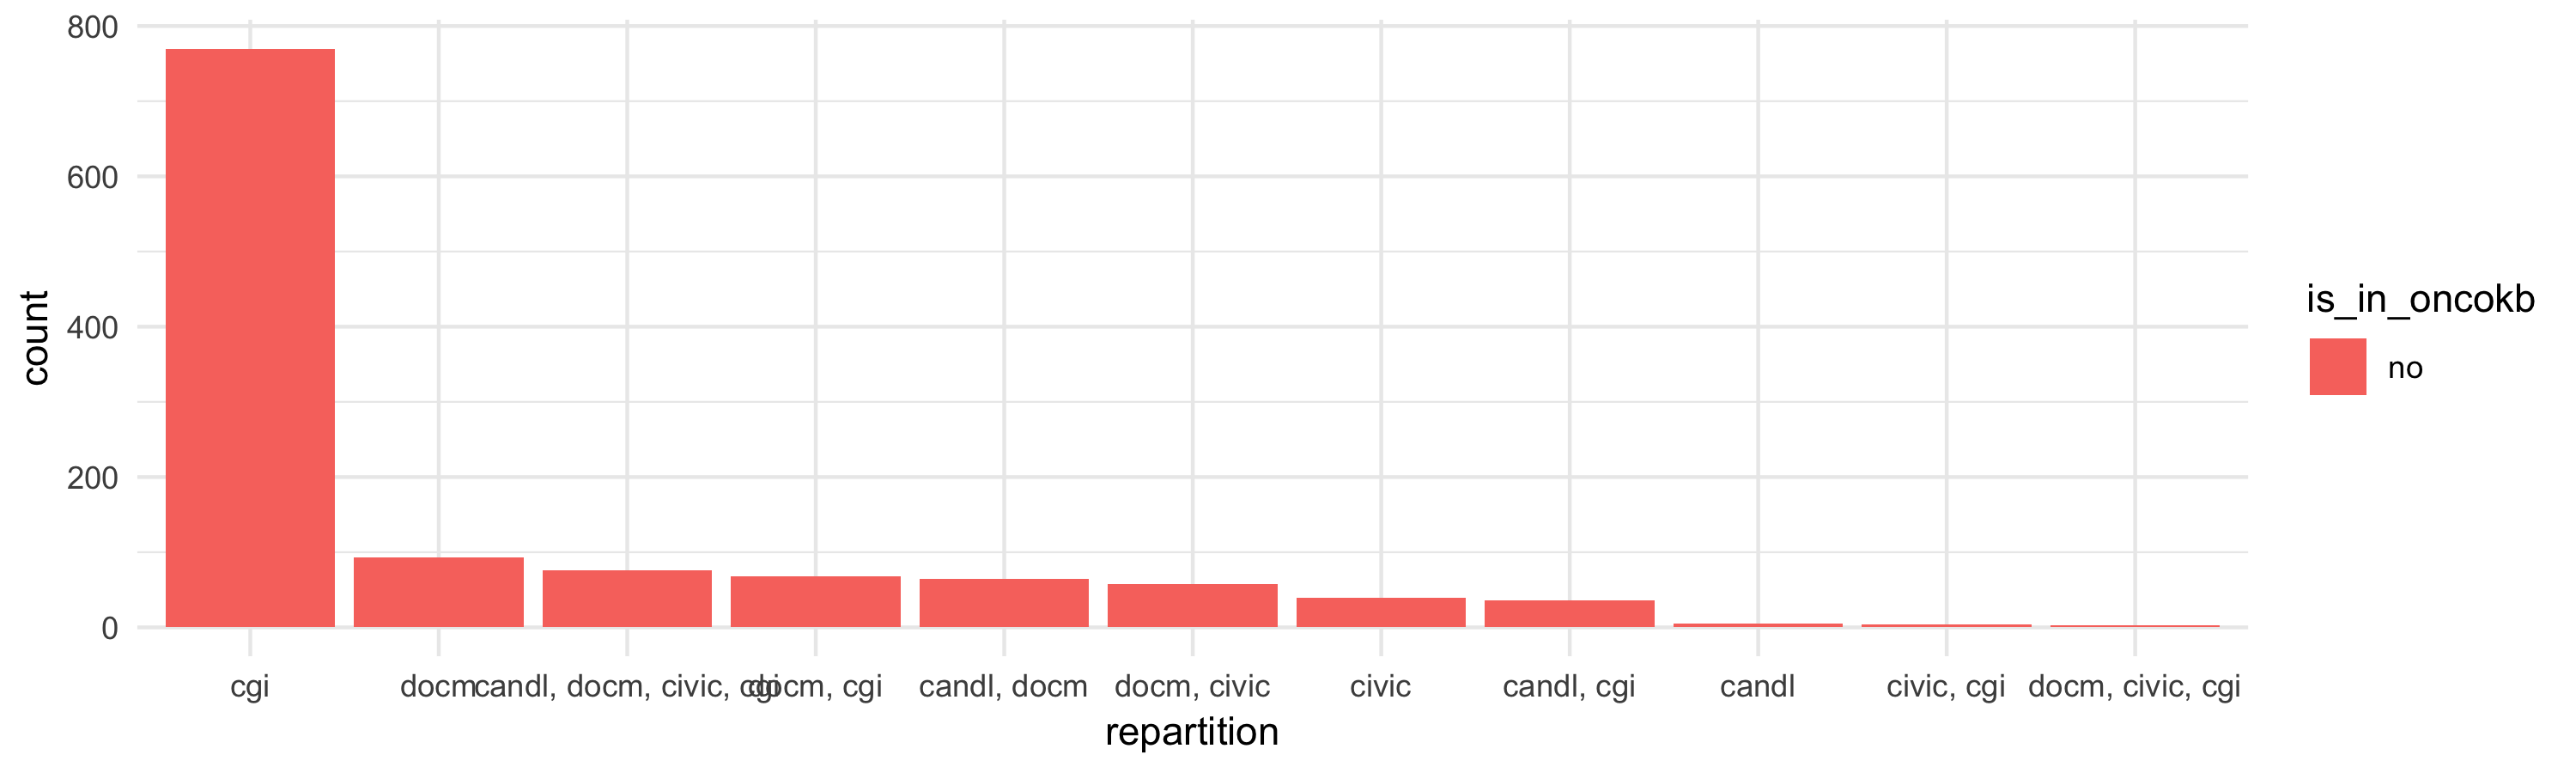

In [58]:
plot_histogram(annotated_mutations,
               "repartition", fill_name = "is_in_oncokb") + tilt_x_label(45)

plot_histogram(annotated_mutations[annotated_mutations$is_in_oncokb == "no",],
               "repartition", fill_name = "is_in_oncokb")

## At the key level

In [59]:
annotated_mutations_key <- as.data.frame(annotated_mutations %>% group_by(mut_key) %>%
                                                                 summarise(count = length(unique(database)),
                                                                           repartition = toString(unique(database)),
                                                                           is_in_oncokb = unique(is_in_oncokb)))

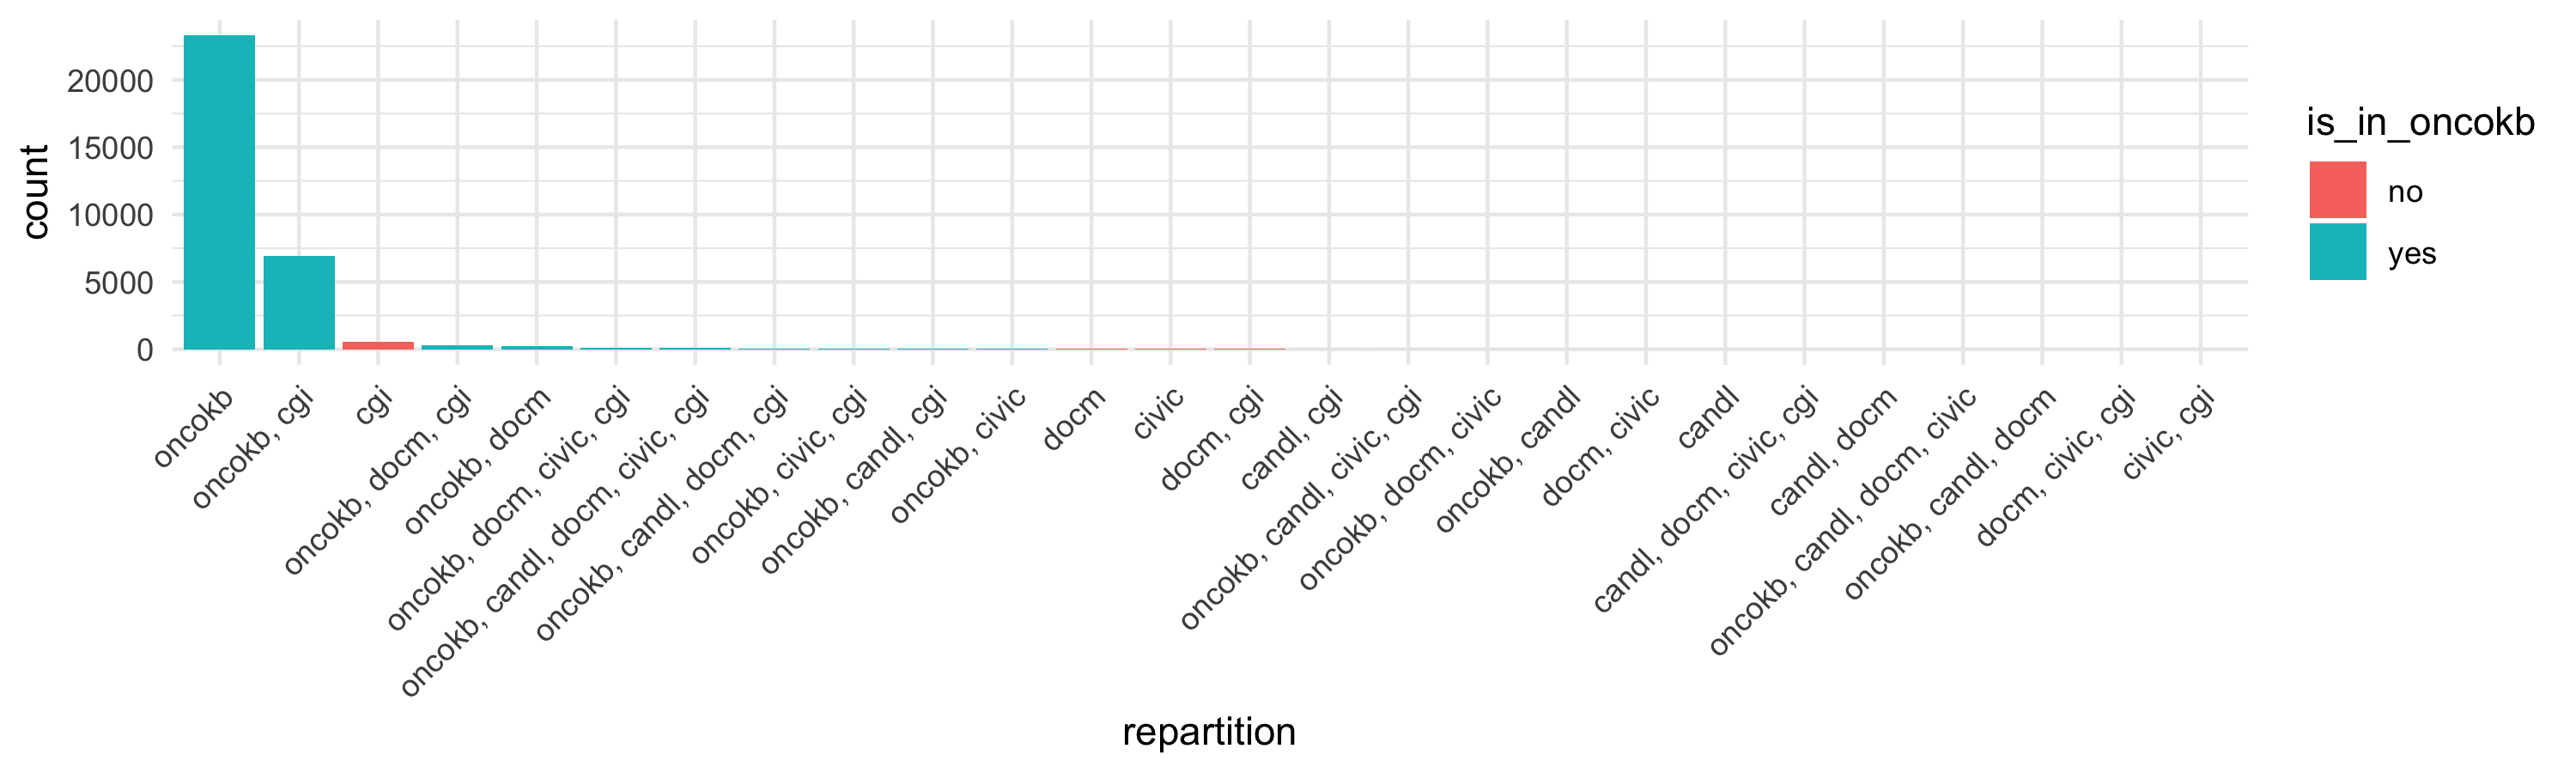

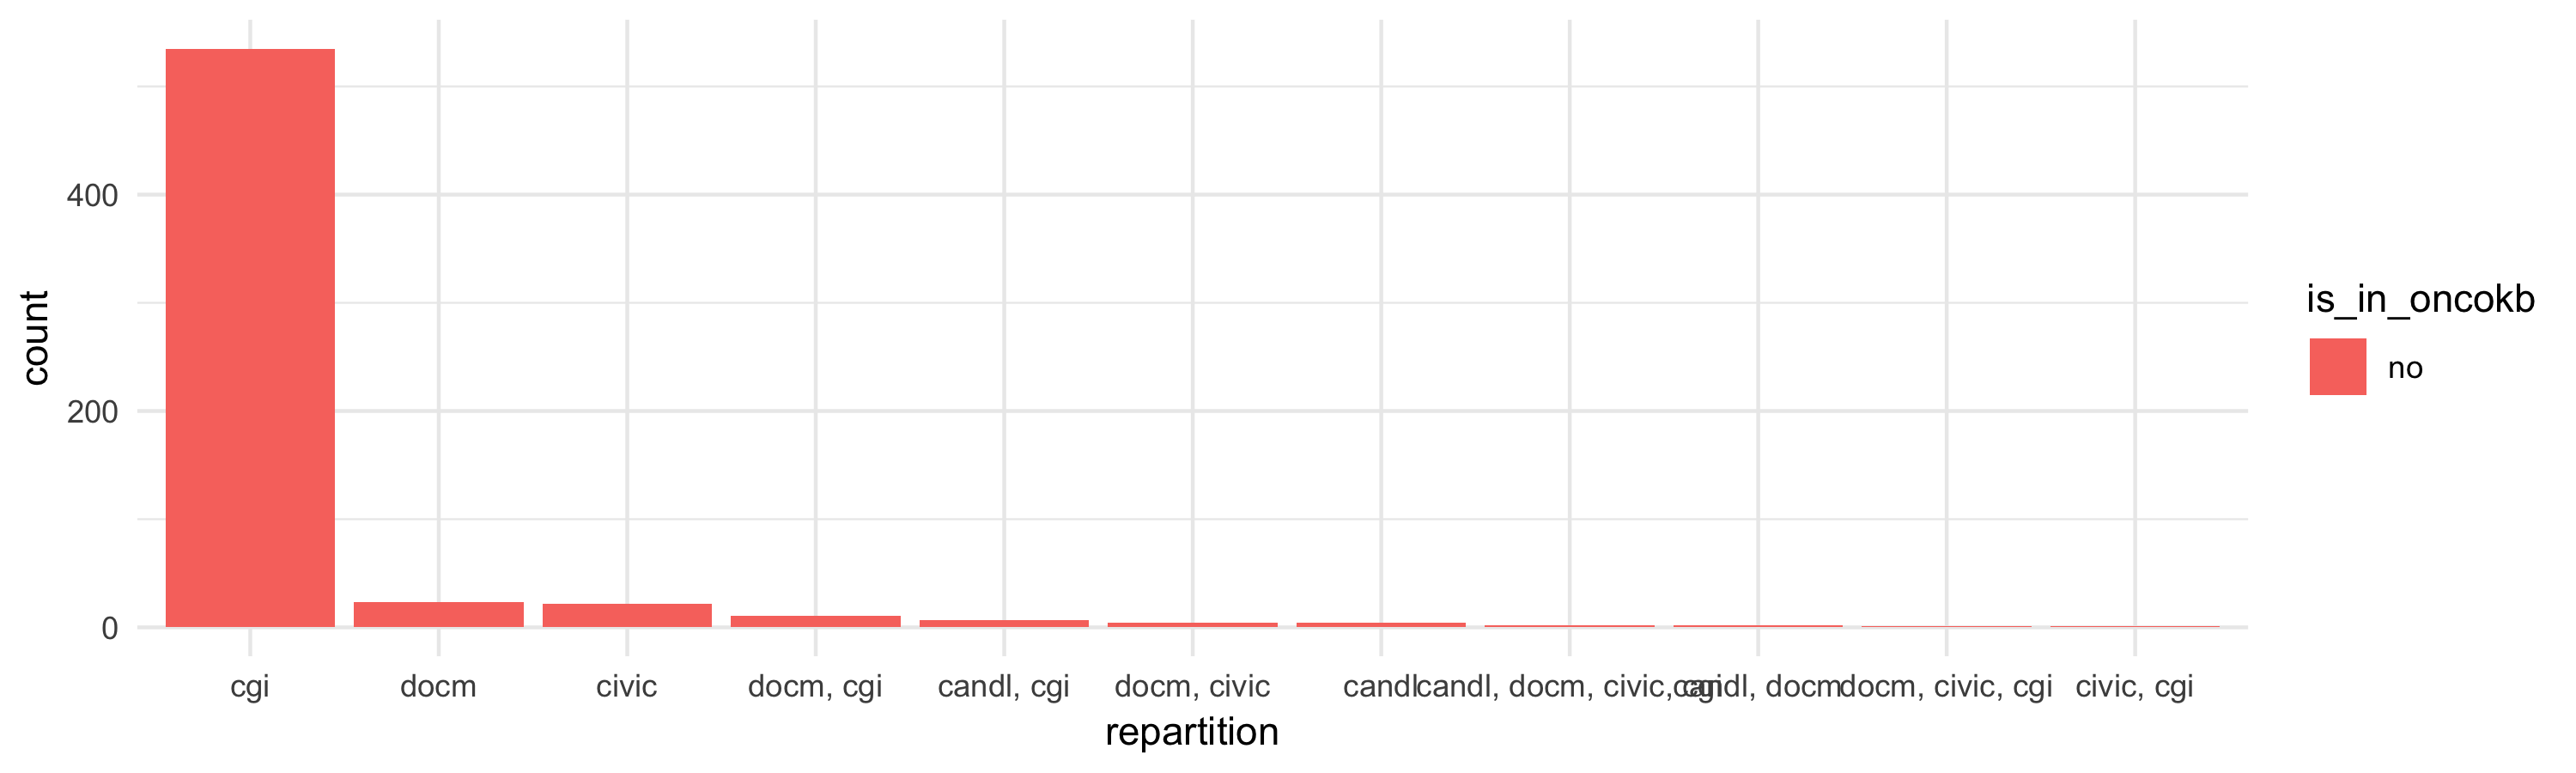

In [60]:
plot_histogram(annotated_mutations_key,
               "repartition", fill_name = "is_in_oncokb") + tilt_x_label(45)

plot_histogram(annotated_mutations_key[annotated_mutations_key$is_in_oncokb == "no",],
               "repartition", fill_name = "is_in_oncokb")

## Mutations not in OncoKB

In [61]:
# number of rows
nrow(annotated_mutations[annotated_mutations$is_in_oncokb == "no",])

# number of distinct mutations
length(unique(annotated_mutations$mut_key[annotated_mutations$is_in_oncokb == "no"]))

[1] 1216

[1] 612

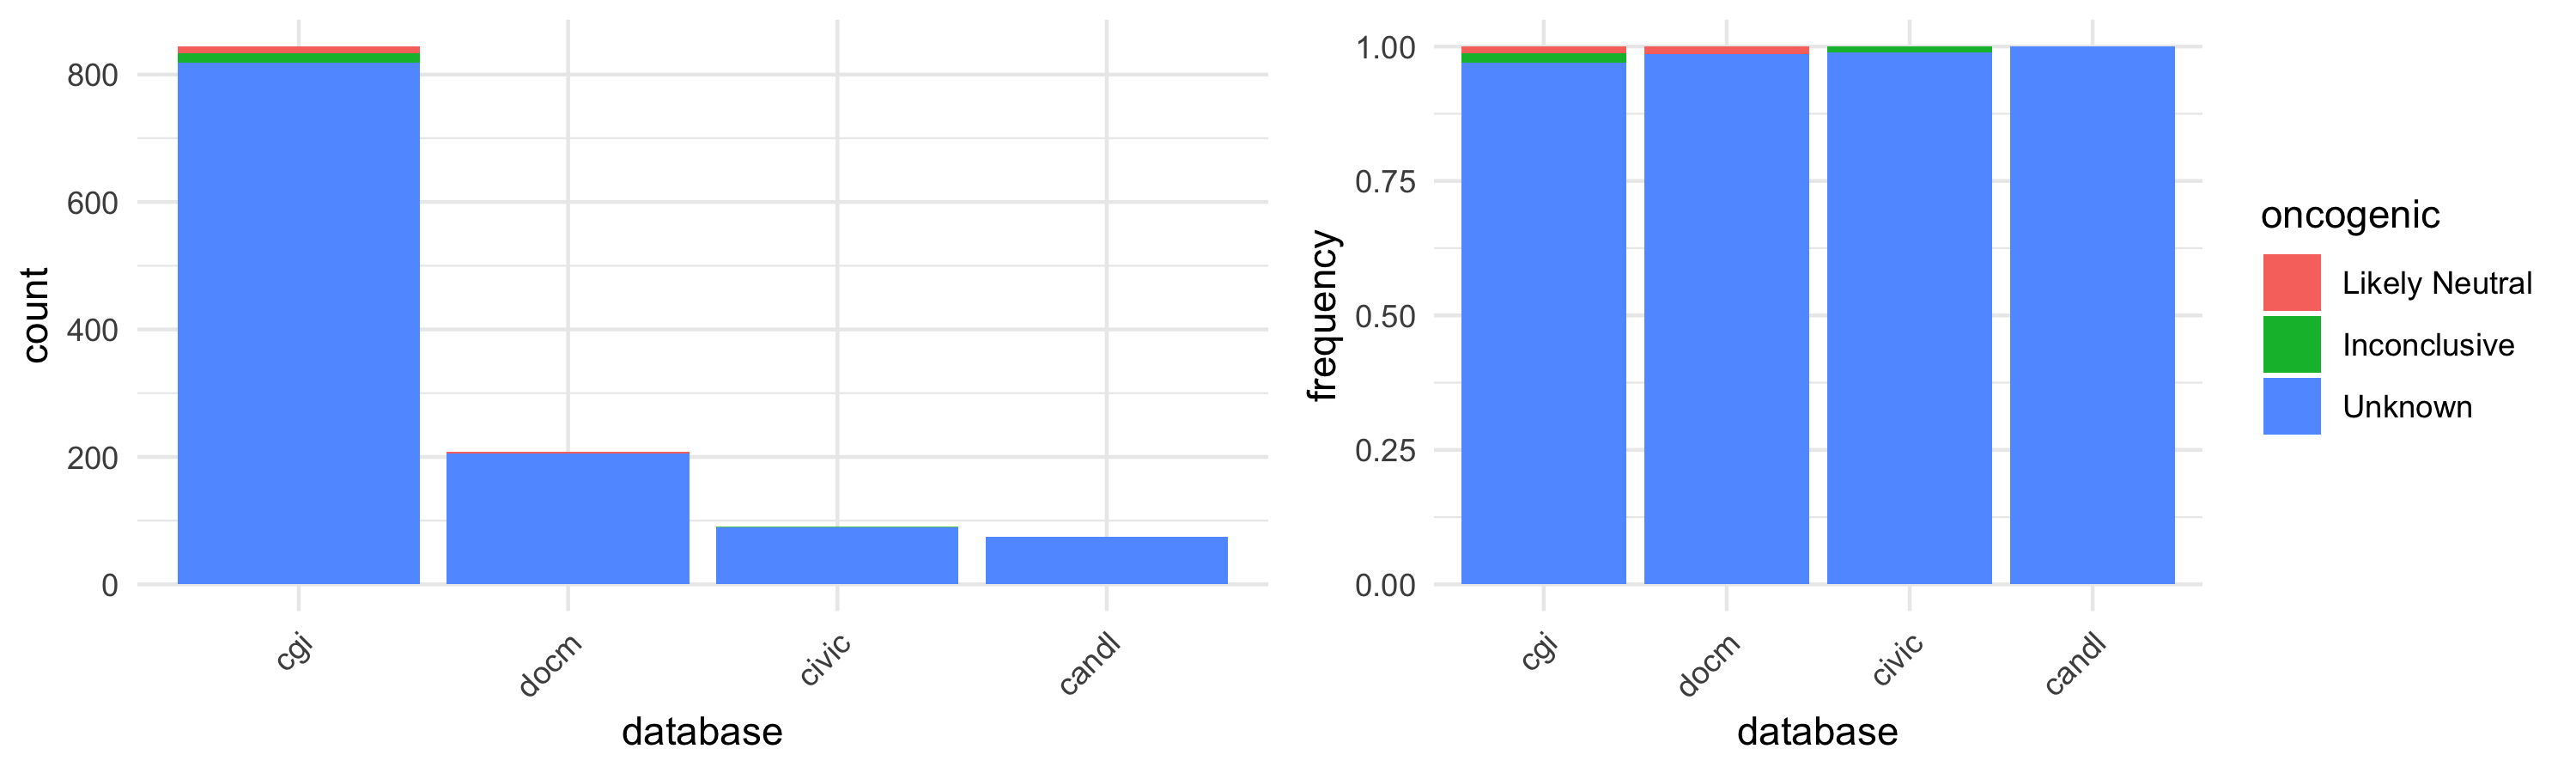

In [62]:
plot_contingency_table_as_histograms(annotated_mutations[annotated_mutations$is_in_oncokb == "no",], 
                                     "database", "oncogenic")

In [63]:
colnames = c("is_in_oncokb", "is_in_candl", "is_in_docm", "is_in_civic", "is_in_cgi")

table <- data.frame()

for (col in colnames) {
    table <- rbind(table, impact %>% filter(!! sym(col) == "yes") %>%
                                     summarise(oncokb = sum(is_in_oncokb == "yes"),
                                               candl  = sum(is_in_candl  == "yes"),
                                               docm   = sum(is_in_docm   == "yes"),
                                               civic  = sum(is_in_civic  == "yes"),
                                               cgi    = sum(is_in_cgi    == "yes")))
}

table <- as.table(as.matrix(table))
rownames(table) <- colnames(table)
table

       oncokb candl  docm civic   cgi
oncokb  77852 10177 22857 14614 36918
candl   10177 10251  9939  9008 10191
docm    22857  9939 23065 14340 20865
civic   14614  9008 14340 14704 14554
cgi     36918 10191 20865 14554 37762

# Study shared genes

VENN diagram?

In [64]:
oncokb <- read.table("../../data/other_databases/allAnnotatedVariants.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [65]:
oncokb_genes <- unique(oncokb$Gene)
candl_genes  <- unique(candl$Gene)
docm_genes   <- unique(docm$gene)
civic_genes  <- unique(civic$gene)
cgi_genes    <- unique(cgi$gene)

## Study genes sharing

In [66]:
oncokb_genes <- as.data.frame(unique(oncokb$Gene))
candl_genes  <- as.data.frame(unique(candl$Gene))
docm_genes   <- as.data.frame(unique(docm$gene))
civic_genes  <- as.data.frame(unique(civic$gene))
cgi_genes    <- as.data.frame(unique(cgi$gene))

colnames(oncokb_genes) <- "gene"
colnames(candl_genes)  <- "gene"
colnames(docm_genes)  <- "gene"
colnames(civic_genes)  <- "gene"
colnames(cgi_genes)    <- "gene"

oncokb_genes$database <- "oncokb"
candl_genes$database  <- "candl"
docm_genes$database   <- "docm"
civic_genes$database  <- "civic"
cgi_genes$database    <- "cgi"

annotated_genes <- rbind(oncokb_genes, candl_genes, docm_genes, civic_genes, cgi_genes)

In [67]:
annotated_genes <- as.data.frame(annotated_genes %>% group_by(gene) %>%
                                                     summarise(count = length(unique(database)),
                                                               repartition = toString(unique(database)),
                                                               in_onco_kb = grepl("oncokb", repartition)))

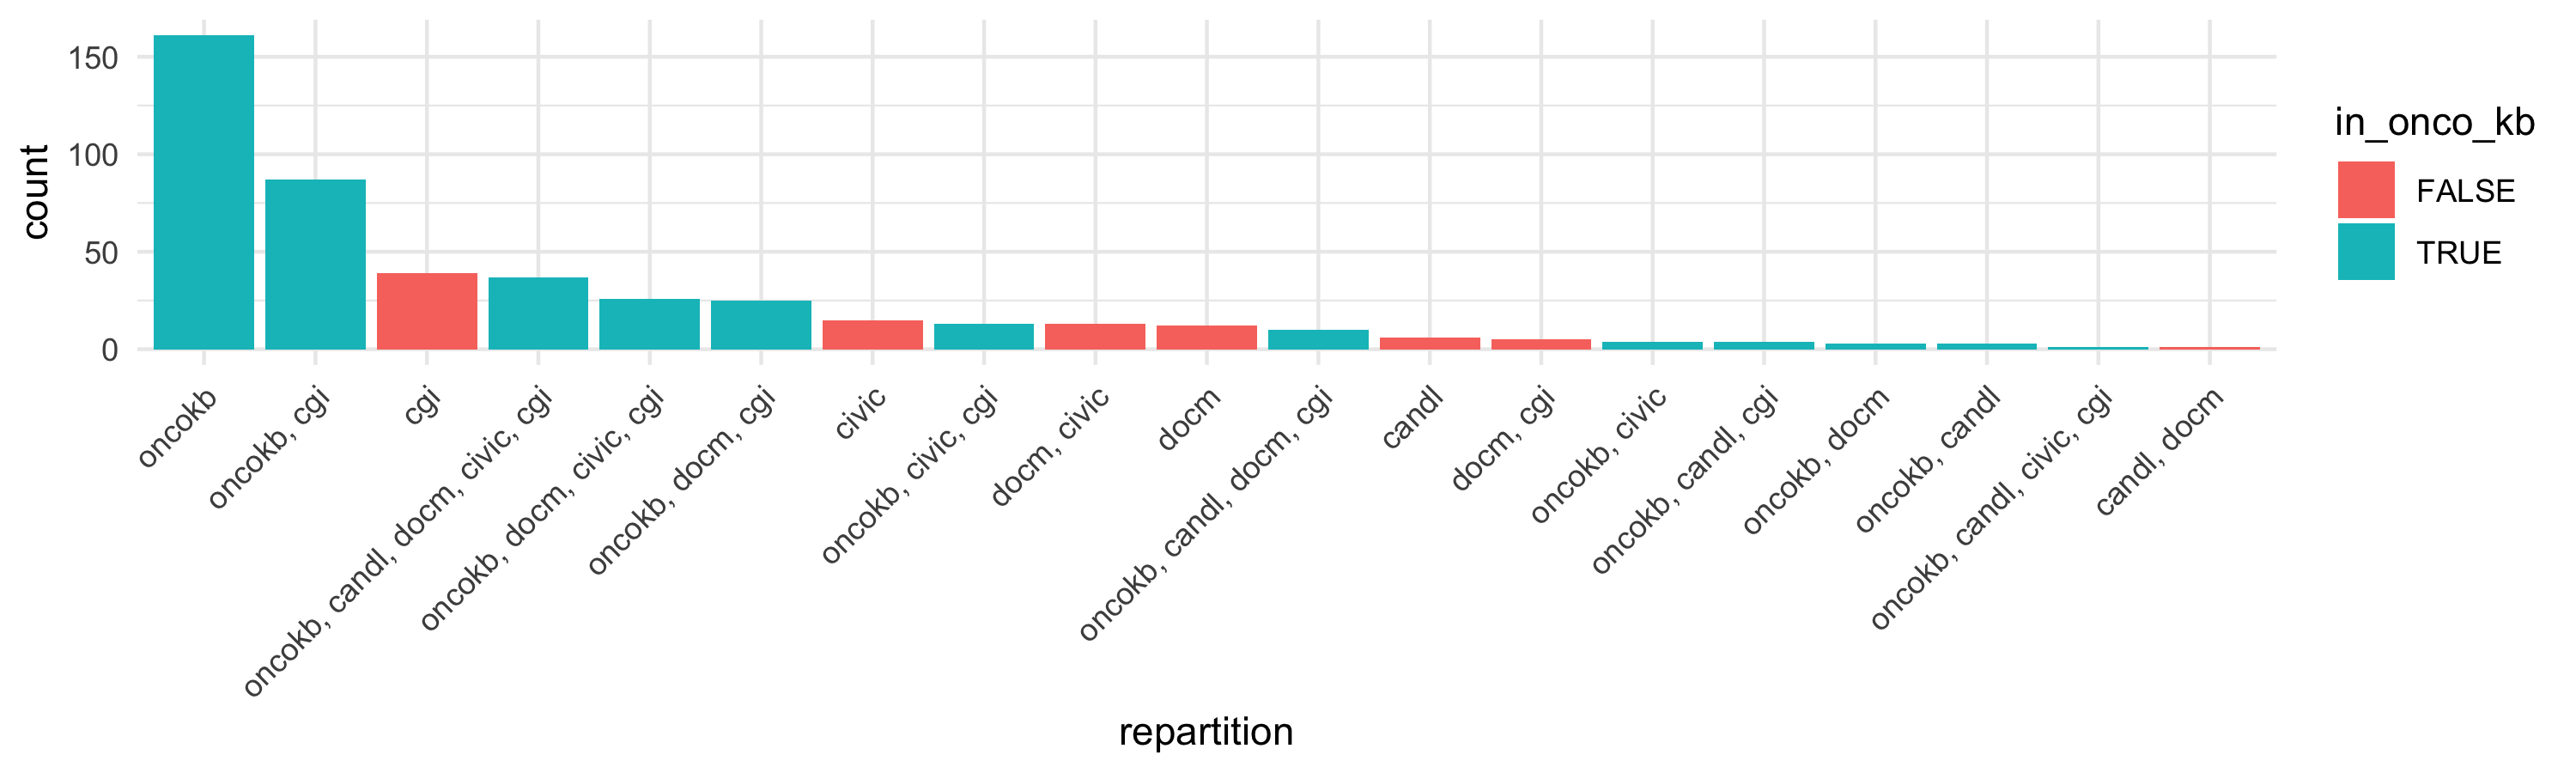

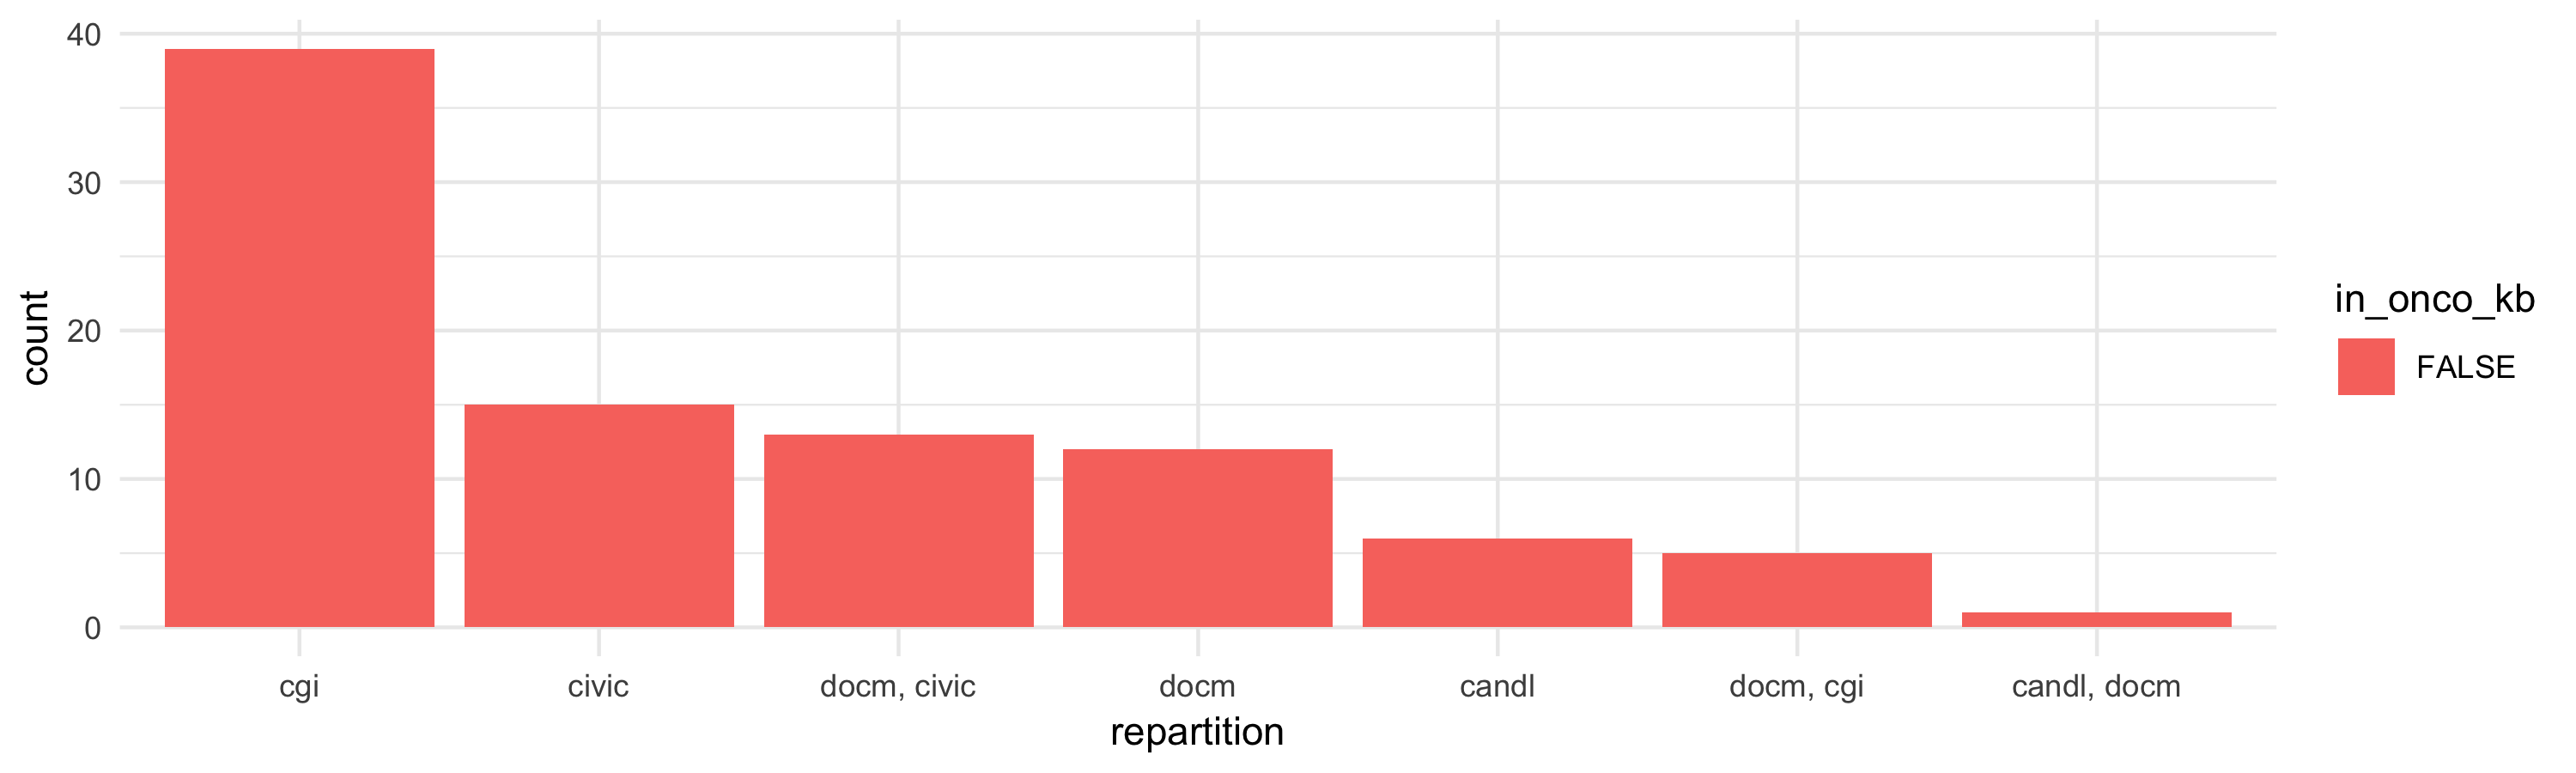

In [68]:
plot_histogram(annotated_genes,
               "repartition", fill = "in_onco_kb") + tilt_x_label(45)
plot_histogram(annotated_genes[! annotated_genes$in_onco_kb,],
               "repartition", fill = "in_onco_kb")

In [69]:
as.character(annotated_genes$gene[annotated_genes$count == 5])

table(annotated_genes$repartition[annotated_genes$count == 4])
as.character(annotated_genes$gene[annotated_genes$count == 4])

table(annotated_genes$repartition[annotated_genes$count == 3])
as.character(annotated_genes$gene[annotated_genes$count == 3])

table(annotated_genes$repartition[annotated_genes$count == 2])
as.character(annotated_genes$gene[annotated_genes$count == 2])

[1] "ABL1"   "AKT1"   "ALK"    "ARAF"   "BRAF"   "BTK"    "CDK4"   "DDR2"  
 [9] "EGFR"   "ERBB2"  "ERBB3"  "ERBB4"  "ESR1"   "FGFR2"  "FGFR3"  "FLT3"  
[17] "GNAQ"   "GNAS"   "IDH1"   "IDH2"   "JAK1"   "JAK2"   "JAK3"   "KDR"   
[25] "KIT"    "KRAS"   "MAP2K1" "MAP2K2" "MET"    "MTOR"   "MYD88"  "NRAS"  
[33] "PDGFRA" "PIK3CA" "RAC1"   "RET"    "SMO"


oncokb, candl, civic, cgi  oncokb, candl, docm, cgi  oncokb, docm, civic, cgi 
                        1                        10                        26 

[1] "AKT3"   "AR"     "ATM"    "B2M"    "BRCA1"  "CDKN2A" "CHEK2"  "CSF3R" 
 [9] "CTNNB1" "DNMT3A" "ERCC2"  "EZH2"   "FGFR1"  "FGFR4"  "FOXL2"  "GNA11" 
[17] "HRAS"   "IL7R"   "MAPK1"  "MLH1"   "MYC"    "NOTCH1" "NPM1"   "PIK3R1"
[25] "PTEN"   "PTPN11" "RAF1"   "RB1"    "RHOA"   "ROS1"   "RUNX1"  "SF3B1" 
[33] "STK11"  "TP53"   "TSC2"   "U2AF1"  "VHL"


oncokb, candl, cgi oncokb, civic, cgi  oncokb, docm, cgi 
                 4                 13                 25 

[1] "ACVR1"   "AKT2"    "APC"     "BRCA2"   "CARD11"  "CBL"     "CCND3"  
 [8] "CREBBP"  "CRLF2"   "EP300"   "ETV6"    "FANCA"   "FBXW7"   "H3F3A"  
[15] "MED12"   "MEN1"    "MPL"     "MSH2"    "MSH6"    "MYCN"    "NF2"    
[22] "NFE2L2"  "NTRK3"   "PIK3R2"  "PLCG2"   "PMS2"    "POLE"    "PPP2R1A"
[29] "PPP6C"   "PTPRD"   "RAD51D"  "RHEB"    "RIT1"    "SMAD4"   "SOS1"   
[36] "SPOP"    "SRC"     "STAT3"   "TERT"    "TSC1"    "WT1"     "XPO1"


  candl, docm     docm, cgi   docm, civic oncokb, candl   oncokb, cgi 
            1             5            13             3            87 
oncokb, civic  oncokb, docm 
            4             3 

[1] "ATR"      "AURKA"    "AXIN2"    "BAP1"     "BARD1"    "BCL10"   
  [7] "BCL2"     "BLM"      "BMPR1A"   "BRIP1"    "CASP8"    "CCND1"   
 [13] "CDC73"    "CDH1"     "CDK12"    "CDK6"     "CDKN1B"   "CDKN2B"  
 [19] "CEBPA"    "CRBN"     "CTCF"     "CTLA4"    "CYSLTR2"  "DICER1"  
 [25] "DIS3"     "ELF3"     "EPAS1"    "ERCC3"    "ERCC4"    "ERRFI1"  
 [31] "FAM175A"  "FANCC"    "FAS"      "FAT1"     "FH"       "FLCN"    
 [37] "FOXA1"    "FOXO1"    "FOXP1"    "GLI1"     "HIST1H1C" "HNF1A"   
 [43] "IGF1R"    "KDM5C"    "KEAP1"    "KLF4"     "KNSTRN"   "MAP2K4"  
 [49] "MAX"      "MDM2"     "MDM4"     "MEF2B"    "MITF"     "MRE11A"  
 [55] "MUTYH"    "MYOD1"    "NBN"      "NF1"      "NTRK1"    "NUP93"   
 [61] "PALB2"    "PDGFRB"   "PIK3CB"   "PIK3CD"   "PIM1"     "PMS1"    
 [67] "PTCH1"    "PTPRT"    "RAB35"    "RAD50"    "RAD51C"   "RAD54L"  
 [73] "RASA1"    "RECQL4"   "RRAS2"    "RXRA"     "SDHA"     "SDHB"    
 [79] "SDHC"     "SDHD"     "SETD2"    "SH2B3"    "SHOC2"    "SMAD2"   
 [85] "SMAD3"    "SMARCA4"  "SOX9"     "SRSF2"    "STAT5B"   "TCF3"    
 [91] "TET2"     "TGFBR1"   "TGFBR2"   "TMEM127"  "TYK2"     "WHSC1"   
 [97] "XRCC2"    "ROCK1"    "ABCB1"    "ABCG2"    "CSF1R"    "EPHA2"   
[103] "EPHB2"    "ETS2"     "FCGR2A"   "FCGR3A"   "GATA2"    "GSTP1"   
[109] "HERC2"    "MGMT"     "MTHFR"    "NQO1"     "NT5C2"    "PML"     
[115] "SETBP1"   "XRCC1"